In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import tensorflow as tf
from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.utils import plot_model,pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model, Input, layers, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization

In [2]:
#read csv files

hot_finbert = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_finbert_ret.csv')
hot_chatgpt = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_chatgpt_ret.csv')
hot_roberta = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_roberta_ret.csv')
new_finbert = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_finbert_ret.csv')
new_chatgpt = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_chatgpt_ret.csv')
new_roberta = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_roberta_ret.csv')
hot_vader = pd.read_csv('drive/MyDrive/Dissertation/CSV/hot_vader_ret.csv')
new_vader = pd.read_csv('drive/MyDrive/Dissertation/CSV/new_vader_ret.csv')


In [3]:
def plot_loss_and_accuracy(history):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()


In [4]:
def plot_week_eval(accuracy,precision,recall,loss):
  labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
  fig, axes = plt.subplots(2, 2, figsize=(18, 12))
  # Accuracy
  axes[0, 0].plot(labels, accuracy, marker='o')
  axes[0, 0].set_title('Accuracy')
  axes[0, 0].grid(True)
  # Precision
  axes[0, 1].plot(labels, precision, marker='o')
  axes[0, 1].set_title('Precision')
  axes[0, 1].grid(True)
  #Recall
  axes[1, 0].plot(labels, recall, marker='o')
  axes[1, 0].set_title('Recall')
  axes[1, 0].grid(True)
  #Loss
  axes[1, 1].plot(labels, loss, marker='o')
  axes[1, 1].set_title('Loss')
  axes[1, 1].grid(True)

  plt.show()


In [19]:
def model_CNN_weekly(df, return_day, max_words=10000):
    # Preprocessing
    df['text'] = df['text'].astype(str)
    label_dummies = pd.get_dummies(df['label'], prefix='label')
    ticker_dummies = pd.get_dummies(df['ticker'], prefix='ticker')
    df = pd.concat([df, label_dummies, ticker_dummies], axis=1)
    df['score'] = df['score'].astype(float)

    # Feature and Target Variables
    X = df[['text'] + list(label_dummies.columns) + list(ticker_dummies.columns) + ['score', 'open', 'high', 'low', 'close', 'vol']]
    y = (df[f'ret_{return_day}'] > 0).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Text Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Model Inputs
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    ticker_input = Input(shape=(len(ticker_dummies.columns),), name='ticker_input')
    label_input = Input(shape=(len(label_dummies.columns),), name='label_input')
    score_input = Input(shape=(1,), name='score_input')
    market_input = Input(shape=(5,), name='market_input')

    # Model Layers
    text_embedding = layers.Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool = MaxPooling1D(3)(text_conv)
    text_flat = GlobalMaxPooling1D()(text_pool)
    text_dropout = Dropout(0.5)(text_flat)

    market_dense = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(market_input)
    market_dropout = Dropout(0.5)(market_dense)

    combined_inputs = layers.concatenate([text_dropout, ticker_input, label_input, score_input, market_dropout])

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(68, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Compile and Train Model
    model = Model(inputs=[text_input, ticker_input, label_input, score_input, market_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

    if return_day == 1:
        tf.keras.utils.plot_model(model, show_shapes=True)
        model.summary()


    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train[ticker_dummies.columns].values,
         'label_input': X_train[label_dummies.columns].values, 'score_input': X_train['score'].values,
         'market_input': X_train[['open', 'high', 'low', 'close', 'vol']].values},
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2
    )

    plot_loss_and_accuracy(history)

    # Evaluate the model
    evaluation = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test[ticker_dummies.columns].values,
         'label_input': X_test[label_dummies.columns].values, 'score_input': X_test['score'].values,
         'market_input': X_test[['open', 'high', 'low', 'close', 'vol']].values},
        y_test
    )
    print("Test Accuracy for Returns from day ", return_day, " : {:.2f}%".format(evaluation[1] * 100))
    print("Test Precision for Returns from day ", return_day, " : {:.2f}%".format(evaluation[2] * 100))
    print("Test Recall for Returns from day ", return_day, " : {:.2f}%".format(evaluation[3] * 100))
    print("Test Loss for Returns from day ", return_day, " : {:.4f}".format(evaluation[0]))

    return evaluation


In [29]:
def model_CNN_weekly_vader(df, return_day, max_words=10000):
    # Preprocessing
    df['text'] = df['text'].astype(str)
    ticker_dummies = pd.get_dummies(df['ticker'], prefix='ticker')
    df = pd.concat([df, ticker_dummies], axis=1)
    df['compound'] = df['compound'].astype(float)

    # Feature and Target Variables
    X = df[['text'] + list(ticker_dummies.columns) + ['compound', 'open', 'high', 'low', 'close', 'vol']]
    y = (df[f'ret_{return_day}'] > 0).astype(int)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Text Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X_train['text'])
    train_text_sequences = tokenizer.texts_to_sequences(X_train['text'])
    test_text_sequences = tokenizer.texts_to_sequences(X_test['text'])
    max_sequence_length = max(len(s) for s in train_text_sequences + test_text_sequences)
    train_text_padded = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
    test_text_padded = pad_sequences(test_text_sequences, maxlen=max_sequence_length)

    # Model Inputs
    text_input = Input(shape=(max_sequence_length,), name='text_input')
    ticker_input = Input(shape=(len(ticker_dummies.columns),), name='ticker_input')
    compound_input = Input(shape=(1,), name='compound_input')
    market_input = Input(shape=(5,), name='market_input')

    # Model Layers
    text_embedding = layers.Embedding(input_dim=max_words, output_dim=128)(text_input)
    text_conv = Conv1D(128, 3, activation='relu')(text_embedding)
    text_pool = MaxPooling1D(3)(text_conv)
    text_flat = GlobalMaxPooling1D()(text_pool)
    text_dropout = Dropout(0.5)(text_flat)

    market_dense = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))(market_input)
    market_dropout = Dropout(0.5)(market_dense)

    combined_inputs = layers.concatenate([text_dropout, ticker_input, compound_input, market_dropout])

    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined_inputs)
    x = BatchNormalization()(x)
    x = layers.Dense(68, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Compile and Train Model
    model = Model(inputs=[text_input, ticker_input, compound_input, market_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])

    if return_day == 1:
        tf.keras.utils.plot_model(model, show_shapes=True)
        model.summary()

    history = model.fit(
        {'text_input': train_text_padded, 'ticker_input': X_train[ticker_dummies.columns].values,
         'compound_input': X_train['compound'].values,
         'market_input': X_train[['open', 'high', 'low', 'close', 'vol']].values},
        y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2
    )

    plot_loss_and_accuracy(history)

    # Evaluate the model
    evaluation = model.evaluate(
        {'text_input': test_text_padded, 'ticker_input': X_test[ticker_dummies.columns].values,
         'compound_input': X_test['compound'].values,
         'market_input': X_test[['open', 'high', 'low', 'close', 'vol']].values},
        y_test
    )
    print("Test Accuracy for Returns from day ", return_day, " : {:.2f}%".format(evaluation[1] * 100))
    print("Test Precision for Returns from day ", return_day, " : {:.2f}%".format(evaluation[2] * 100))
    print("Test Recall for Returns from day ", return_day, " : {:.2f}%".format(evaluation[3] * 100))
    print("Test Loss for Returns from day ", return_day, " : {:.4f}".format(evaluation[0]))

    return evaluation


=============  HOT FINBERT CNN  =============== 

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_14 (Conv1D)             (None, 30, 128)      49280       ['embedding_14[0][0]']           
                                                                                                  
 max_pooling1d_14 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_14[0][0]']              
 )                                       

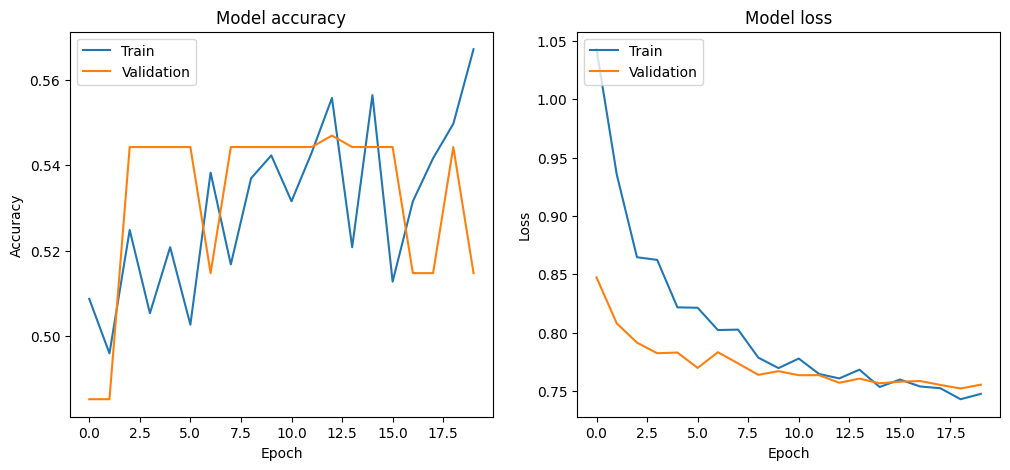

15/15 [==============================] - 0s 5ms/step - loss: 0.7488 - accuracy: 0.5451 - precision: 0.5468 - recall: 0.9084
Test Accuracy for Returns from day  1  : 54.51%
Test Precision for Returns from day  1  : 54.68%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7488
Epoch 1/20
47/47 [==============================] - 9s 145ms/step - loss: 1.0806 - accuracy: 0.4993 - precision: 0.5264 - recall: 0.6269 - val_loss: 0.8672 - val_accuracy: 0.5013 - val_precision: 0.5087 - val_recall: 0.9115
Epoch 2/20
47/47 [==============================] - 4s 89ms/step - loss: 0.9079 - accuracy: 0.5074 - precision: 0.5371 - recall: 0.5641 - val_loss: 0.8377 - val_accuracy: 0.5282 - val_precision: 0.7000 - val_recall: 0.1458
Epoch 3/20
47/47 [==============================] - 2s 45ms/step - loss: 0.8901 - accuracy: 0.4926 - precision: 0.5230 - recall: 0.5716 - val_loss: 0.7961 - val_accuracy: 0.5147 - val_precision: 0.5797 - val_recall: 0.2083
Epoch 4/20
47/47 [=

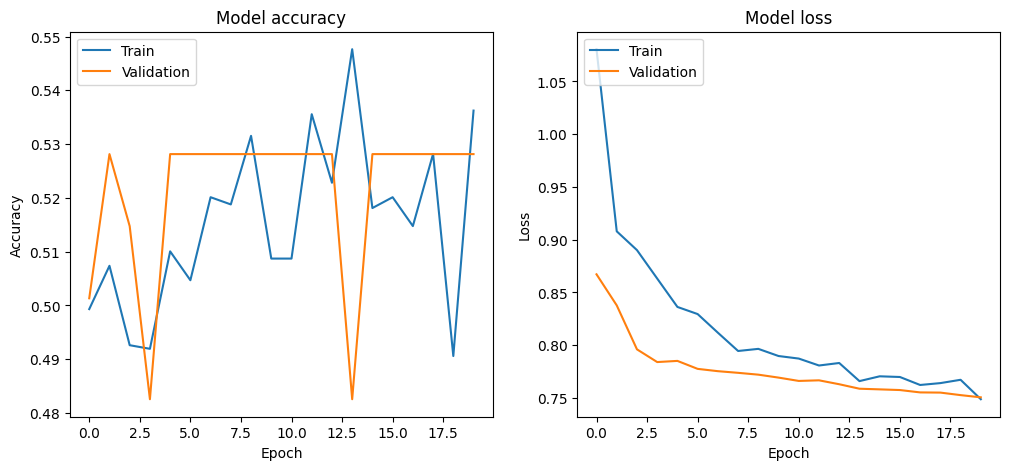

15/15 [==============================] - 0s 4ms/step - loss: 0.7489 - accuracy: 0.5451 - precision: 0.6667 - recall: 0.1880
Test Accuracy for Returns from day  2  : 54.51%
Test Precision for Returns from day  2  : 66.67%
Test Recall for Returns from day  2  : 18.80%
Test Loss for Returns from day  2  : 0.7489
Epoch 1/20
47/47 [==============================] - 10s 145ms/step - loss: 0.9711 - accuracy: 0.5658 - precision: 0.6328 - recall: 0.7143 - val_loss: 0.8023 - val_accuracy: 0.7185 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 88ms/step - loss: 0.8690 - accuracy: 0.5611 - precision: 0.6239 - recall: 0.7359 - val_loss: 0.7454 - val_accuracy: 0.6729 - val_precision: 0.6630 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 55ms/step - loss: 0.8143 - accuracy: 0.5819 - precision: 0.6350 - recall: 0.7662 - val_loss: 0.7367 - val_accuracy: 0.6729 - val_precision: 0.6630 - val_recall: 1.0000
Epoch 4/20
47/47 [

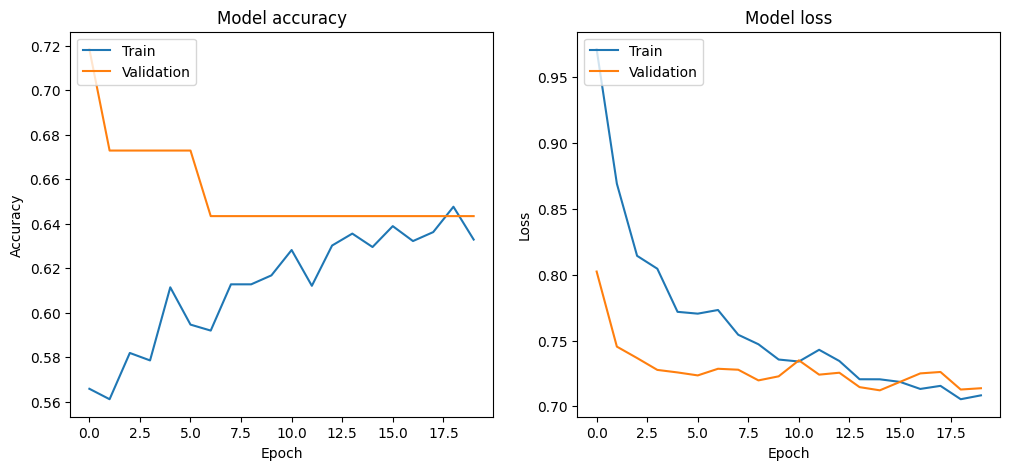

15/15 [==============================] - 0s 4ms/step - loss: 0.7161 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7161
Epoch 1/20
47/47 [==============================] - 9s 133ms/step - loss: 0.9465 - accuracy: 0.6060 - precision: 0.7074 - recall: 0.7512 - val_loss: 0.8239 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 95ms/step - loss: 0.8023 - accuracy: 0.6530 - precision: 0.7101 - recall: 0.8570 - val_loss: 0.7610 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 2s 45ms/step - loss: 0.7971 - accuracy: 0.6416 - precision: 0.7042 - recall: 0.8465 - val_loss: 0.7689 - val_accuracy: 0.6702 - val_precision: 0.6731 - val_recall: 0.9839
Epoch 4/20
47/47 [

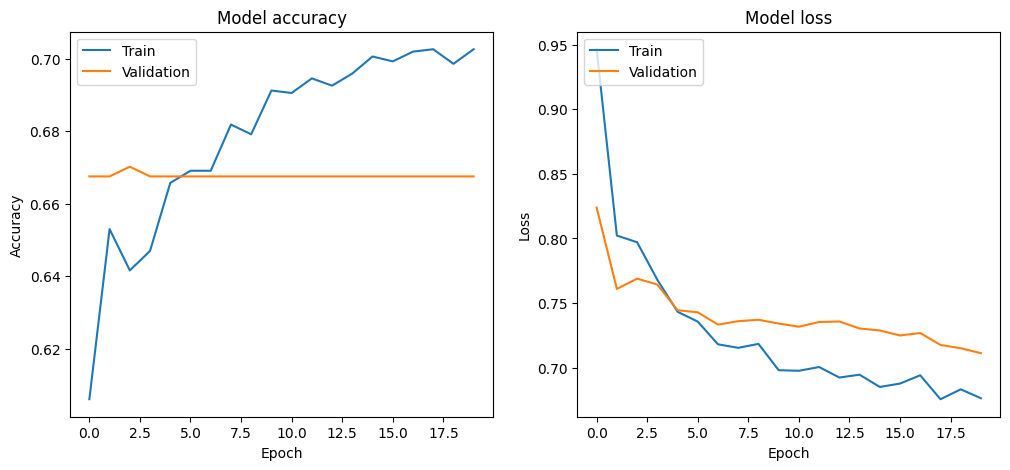

15/15 [==============================] - 0s 6ms/step - loss: 0.7100 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.7100
Epoch 1/20
47/47 [==============================] - 13s 205ms/step - loss: 0.9238 - accuracy: 0.6490 - precision: 0.7826 - recall: 0.7673 - val_loss: 0.7013 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 3s 63ms/step - loss: 0.7447 - accuracy: 0.7416 - precision: 0.7893 - recall: 0.9165 - val_loss: 0.6717 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 73ms/step - loss: 0.7105 - accuracy: 0.7282 - precision: 0.7832 - recall: 0.9054 - val_loss: 0.6473 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/20
47/47 

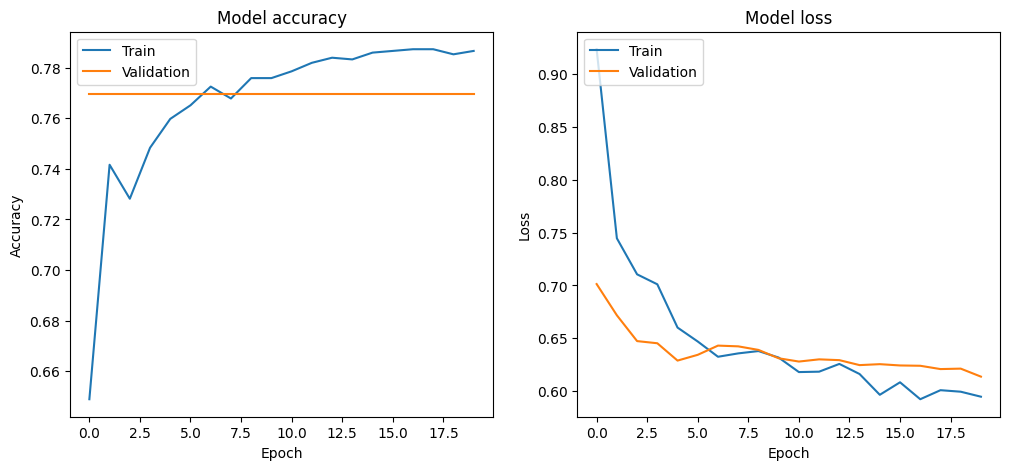

15/15 [==============================] - 0s 5ms/step - loss: 0.5843 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.5843


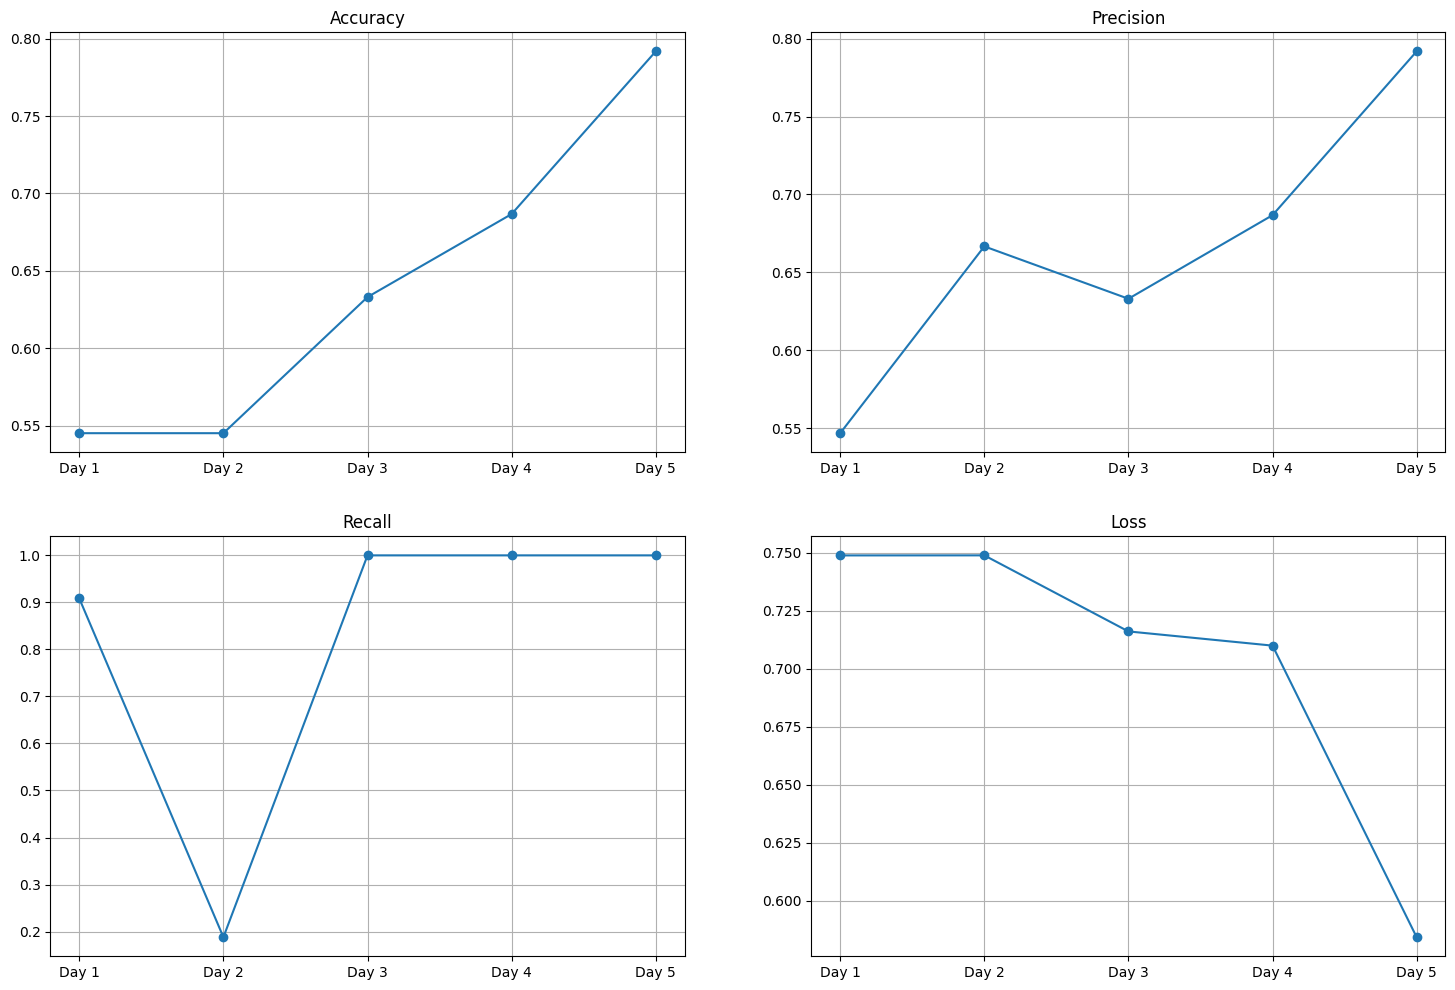

In [20]:
print("=============  HOT FINBERT CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(hot_finbert,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW FINBERT CNN  =============== 

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_19 (Conv1D)             (None, 32, 128)      49280       ['embedding_19[0][0]']           
                                                                                                  
 max_pooling1d_19 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_19[0][0]']              
 )                                       

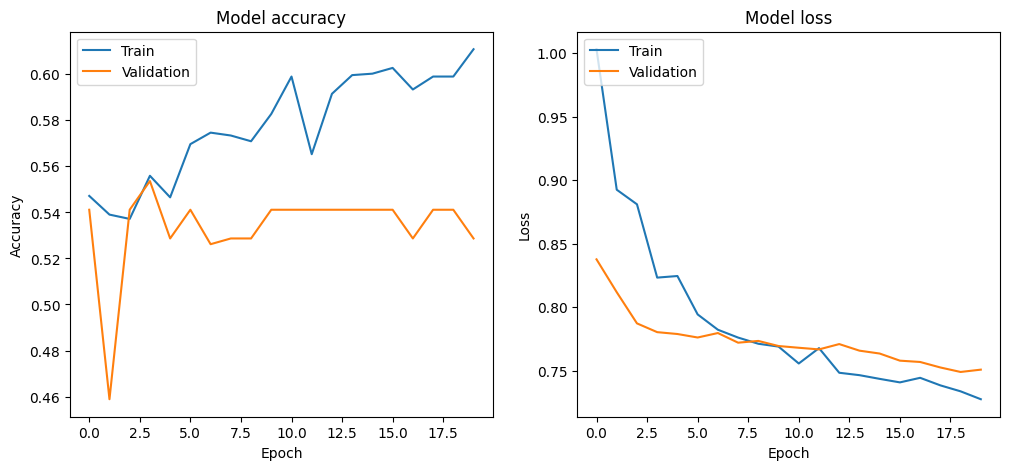

16/16 [==============================] - 0s 9ms/step - loss: 0.7460 - accuracy: 0.5549 - precision: 0.5549 - recall: 1.0000
Test Accuracy for Returns from day  1  : 55.49%
Test Precision for Returns from day  1  : 55.49%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7460
Epoch 1/20
51/51 [==============================] - 9s 119ms/step - loss: 1.0073 - accuracy: 0.5178 - precision: 0.5571 - recall: 0.5989 - val_loss: 0.8371 - val_accuracy: 0.5062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
51/51 [==============================] - 6s 112ms/step - loss: 0.9109 - accuracy: 0.4991 - precision: 0.5405 - recall: 0.5909 - val_loss: 0.8000 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 61ms/step - loss: 0.8684 - accuracy: 0.5091 - precision: 0.5506 - recall: 0.5807 - val_loss: 0.7842 - val_accuracy: 0.5910 - val_precision: 0.5486 - val_recall: 0.9697
Epoch 4/2

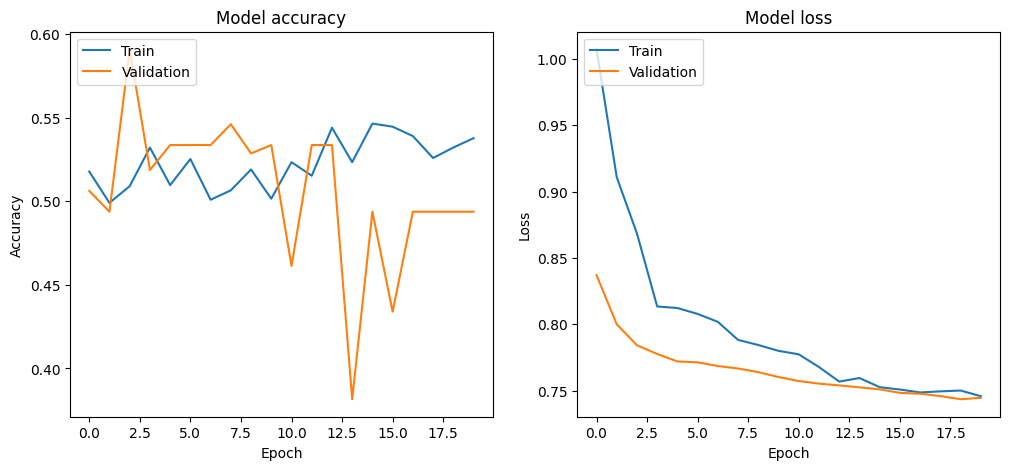

16/16 [==============================] - 0s 4ms/step - loss: 0.7433 - accuracy: 0.5070 - precision: 0.5070 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.70%
Test Precision for Returns from day  2  : 50.70%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7433
Epoch 1/20
51/51 [==============================] - 11s 165ms/step - loss: 1.0360 - accuracy: 0.5328 - precision: 0.6362 - recall: 0.6111 - val_loss: 0.8364 - val_accuracy: 0.4514 - val_precision: 0.6774 - val_recall: 0.0909
Epoch 2/20
51/51 [==============================] - 3s 52ms/step - loss: 0.8736 - accuracy: 0.5590 - precision: 0.6374 - recall: 0.7029 - val_loss: 0.7926 - val_accuracy: 0.4190 - val_precision: 0.4848 - val_recall: 0.1385
Epoch 3/20
51/51 [==============================] - 2s 48ms/step - loss: 0.8384 - accuracy: 0.5790 - precision: 0.6390 - recall: 0.7690 - val_loss: 0.7677 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/20
51/51 

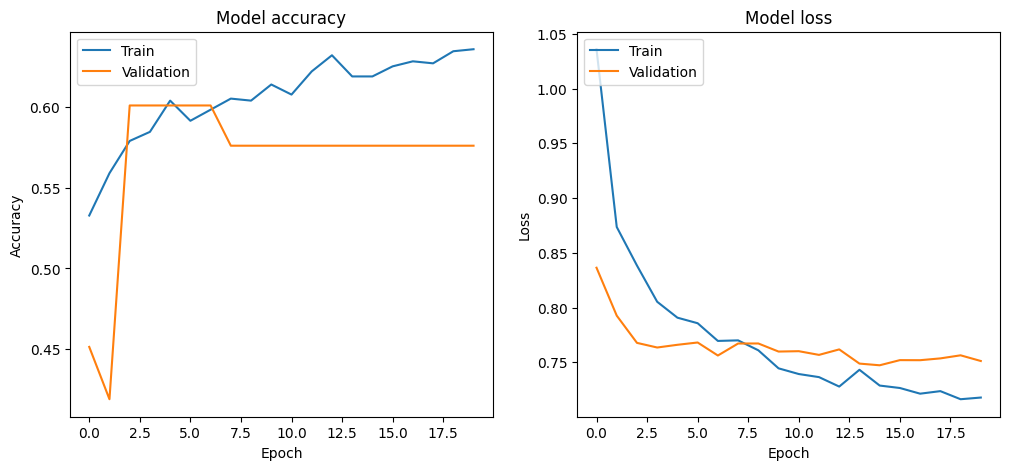

16/16 [==============================] - 0s 4ms/step - loss: 0.7309 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7309
Epoch 1/20
51/51 [==============================] - 10s 125ms/step - loss: 0.8760 - accuracy: 0.6671 - precision: 0.7383 - recall: 0.8534 - val_loss: 0.7616 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 62ms/step - loss: 0.7683 - accuracy: 0.7108 - precision: 0.7500 - recall: 0.9149 - val_loss: 0.7270 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 4s 73ms/step - loss: 0.7503 - accuracy: 0.6914 - precision: 0.7405 - recall: 0.8989 - val_loss: 0.7134 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/20
51/51 

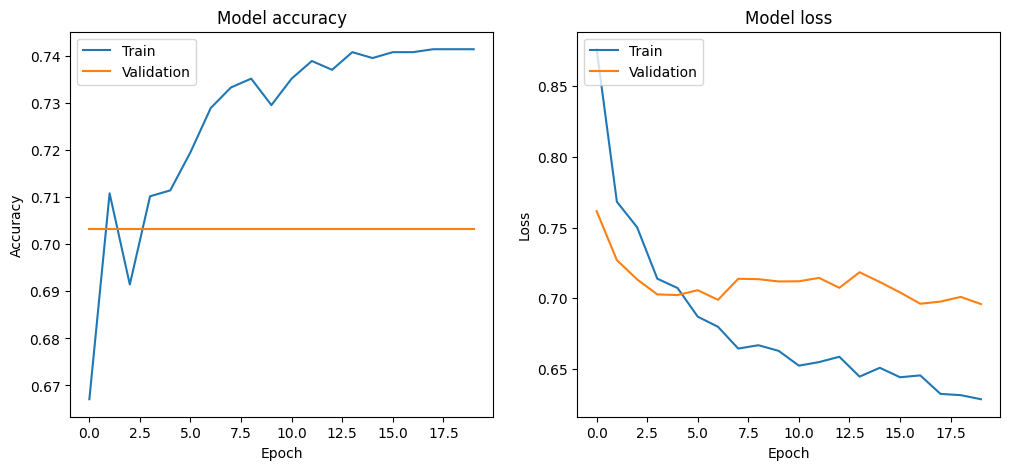

16/16 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6939
Epoch 1/20
51/51 [==============================] - 12s 177ms/step - loss: 0.9123 - accuracy: 0.6334 - precision: 0.8152 - recall: 0.7047 - val_loss: 0.8059 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 3s 59ms/step - loss: 0.7173 - accuracy: 0.7514 - precision: 0.8038 - recall: 0.9147 - val_loss: 0.7110 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 2s 49ms/step - loss: 0.6721 - accuracy: 0.7639 - precision: 0.8098 - recall: 0.9240 - val_loss: 0.6848 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 4/20
51/51 

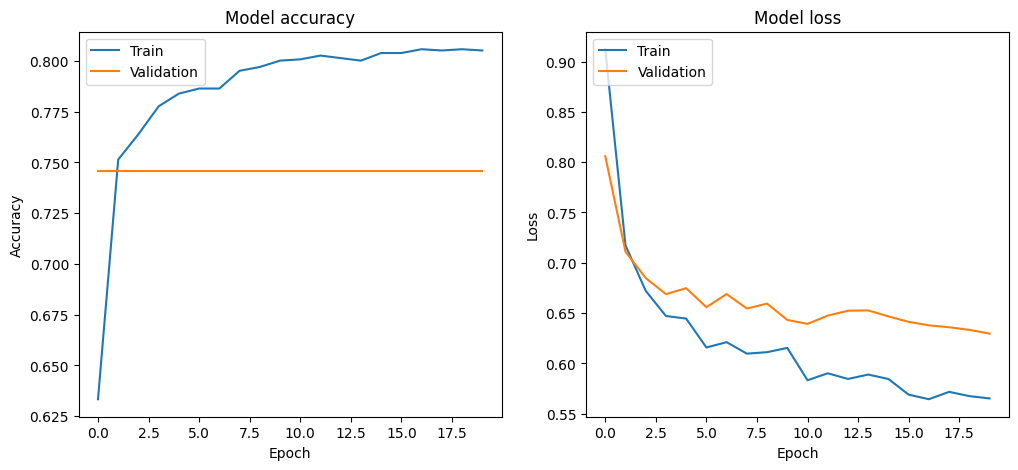

16/16 [==============================] - 0s 4ms/step - loss: 0.6073 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6073


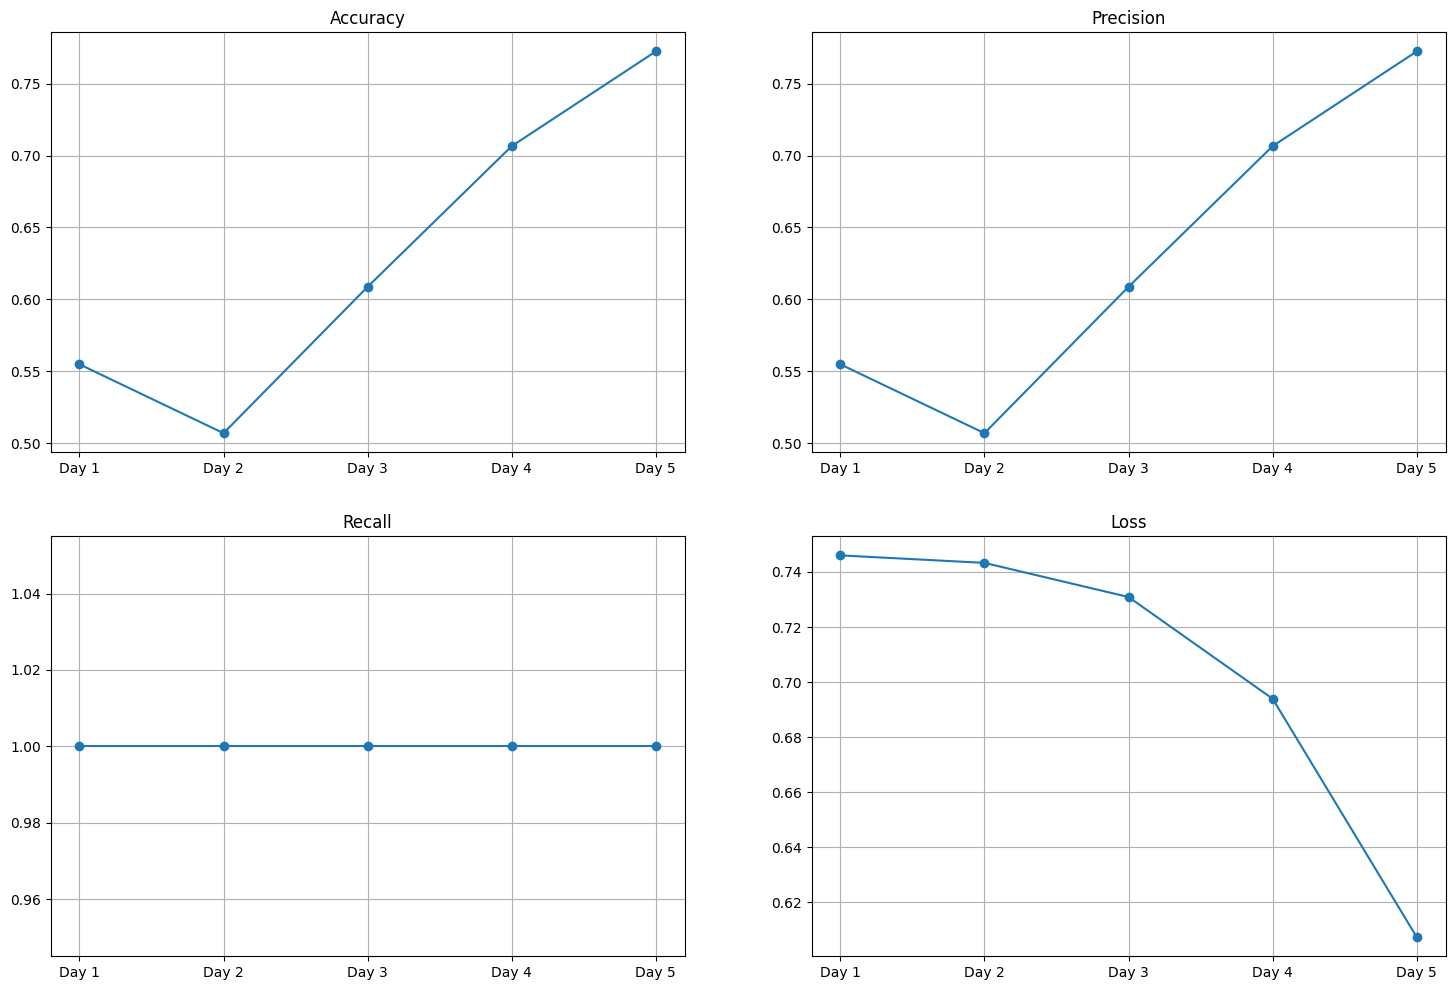

In [21]:
print("=============  NEW FINBERT CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(new_finbert,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT ROBERTA CNN  =============== 

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_24 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_24 (Conv1D)             (None, 30, 128)      49280       ['embedding_24[0][0]']           
                                                                                                  
 max_pooling1d_24 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_24[0][0]']              
 )                                       

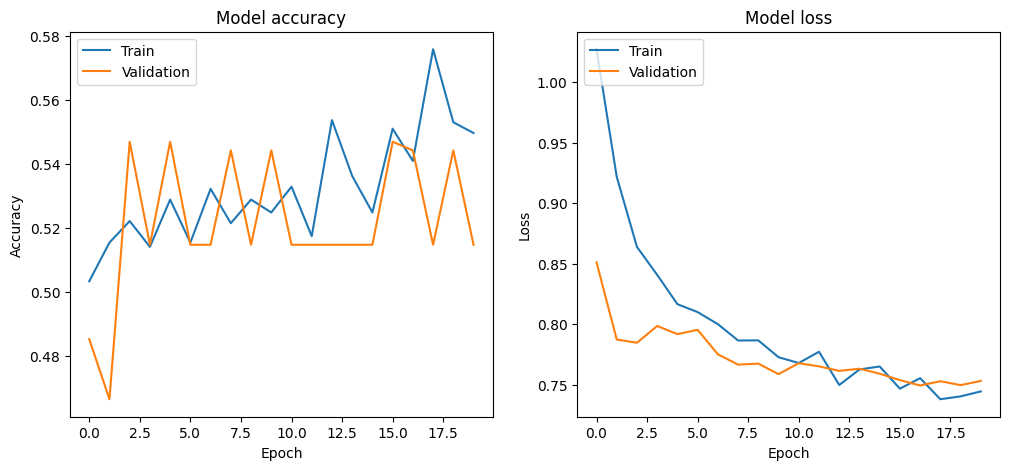

15/15 [==============================] - 0s 5ms/step - loss: 0.7466 - accuracy: 0.5451 - precision: 0.5468 - recall: 0.9084
Test Accuracy for Returns from day  1  : 54.51%
Test Precision for Returns from day  1  : 54.68%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7466
Epoch 1/20
47/47 [==============================] - 10s 148ms/step - loss: 1.0354 - accuracy: 0.5154 - precision: 0.5451 - recall: 0.5616 - val_loss: 0.9202 - val_accuracy: 0.5147 - val_precision: 0.5147 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 80ms/step - loss: 0.9161 - accuracy: 0.5154 - precision: 0.5419 - recall: 0.6018 - val_loss: 0.8184 - val_accuracy: 0.5147 - val_precision: 0.5147 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 2s 53ms/step - loss: 0.8745 - accuracy: 0.4966 - precision: 0.5273 - recall: 0.5578 - val_loss: 0.8026 - val_accuracy: 0.5147 - val_precision: 0.5147 - val_recall: 1.0000
Epoch 4/20
47/47 [

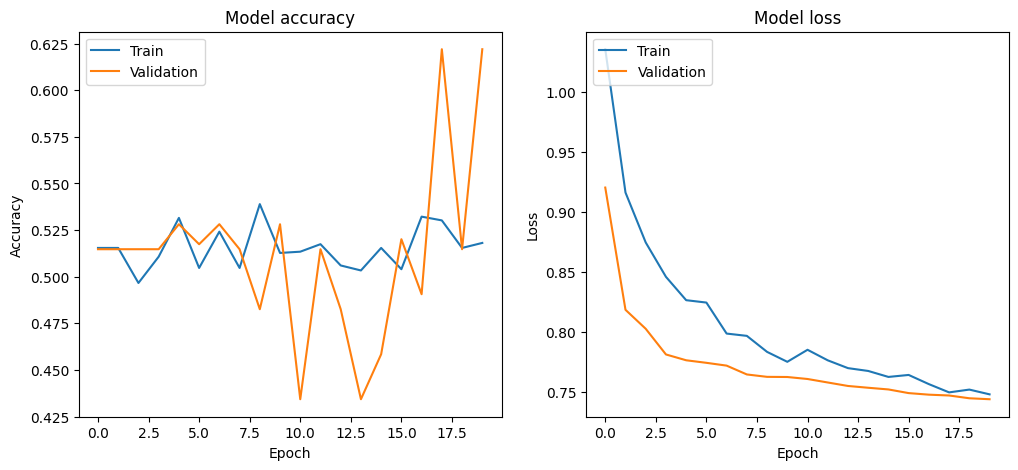

15/15 [==============================] - 0s 4ms/step - loss: 0.7432 - accuracy: 0.5837 - precision: 0.5952 - recall: 0.5342
Test Accuracy for Returns from day  2  : 58.37%
Test Precision for Returns from day  2  : 59.52%
Test Recall for Returns from day  2  : 53.42%
Test Loss for Returns from day  2  : 0.7432
Epoch 1/20
47/47 [==============================] - 13s 203ms/step - loss: 1.0400 - accuracy: 0.5221 - precision: 0.6290 - recall: 0.5595 - val_loss: 0.7926 - val_accuracy: 0.6488 - val_precision: 0.6764 - val_recall: 0.8708
Epoch 2/20
47/47 [==============================] - 3s 72ms/step - loss: 0.9236 - accuracy: 0.5369 - precision: 0.6125 - recall: 0.6894 - val_loss: 0.7334 - val_accuracy: 0.7185 - val_precision: 0.6957 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 4s 88ms/step - loss: 0.8455 - accuracy: 0.5483 - precision: 0.6124 - recall: 0.7403 - val_loss: 0.7263 - val_accuracy: 0.6729 - val_precision: 0.6630 - val_recall: 1.0000
Epoch 4/20
47/47 [

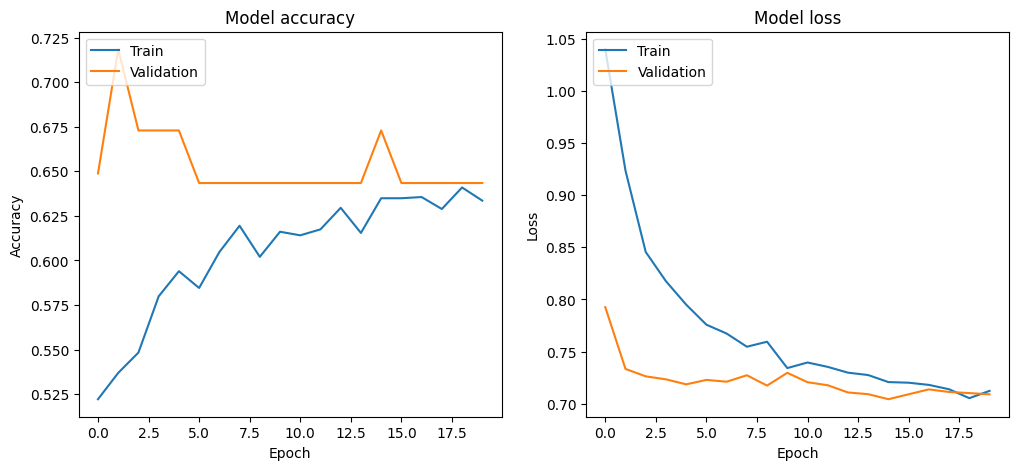

15/15 [==============================] - 0s 5ms/step - loss: 0.7117 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7117
Epoch 1/20
47/47 [==============================] - 11s 169ms/step - loss: 0.9584 - accuracy: 0.5852 - precision: 0.7039 - recall: 0.7092 - val_loss: 0.8844 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 3s 71ms/step - loss: 0.8273 - accuracy: 0.6356 - precision: 0.6961 - recall: 0.8561 - val_loss: 0.7479 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 2s 44ms/step - loss: 0.7740 - accuracy: 0.6436 - precision: 0.7043 - recall: 0.8513 - val_loss: 0.7799 - val_accuracy: 0.6434 - val_precision: 0.8152 - val_recall: 0.6024
Epoch 4/20
47/47 

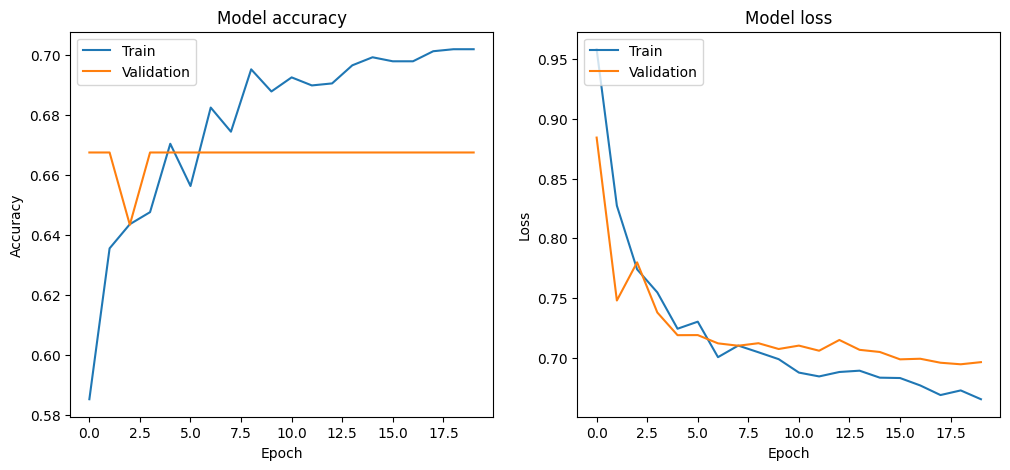

15/15 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6863
Epoch 1/20
47/47 [==============================] - 10s 130ms/step - loss: 0.8639 - accuracy: 0.6718 - precision: 0.7799 - recall: 0.8124 - val_loss: 0.7071 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 4s 82ms/step - loss: 0.7091 - accuracy: 0.7477 - precision: 0.7890 - recall: 0.9275 - val_loss: 0.6982 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 61ms/step - loss: 0.6961 - accuracy: 0.7409 - precision: 0.7817 - recall: 0.9309 - val_loss: 0.6617 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/20
47/47 

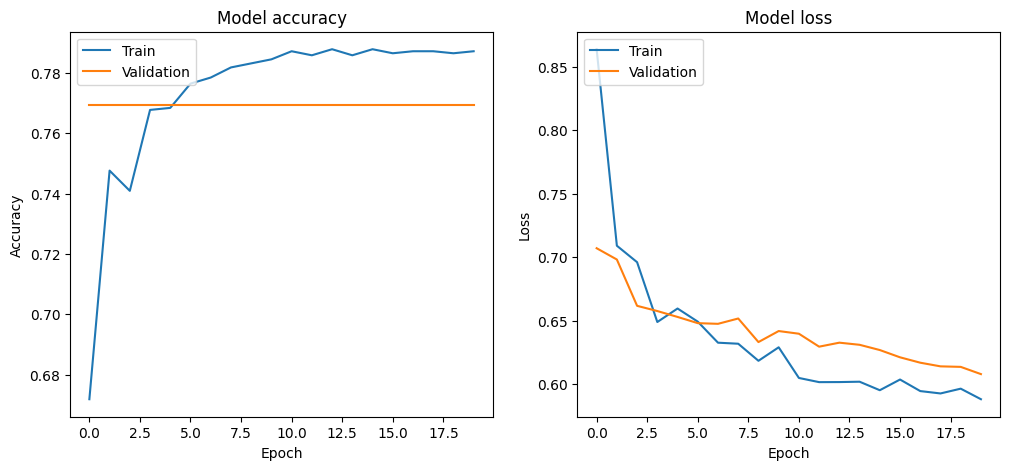

15/15 [==============================] - 0s 5ms/step - loss: 0.5844 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.5844


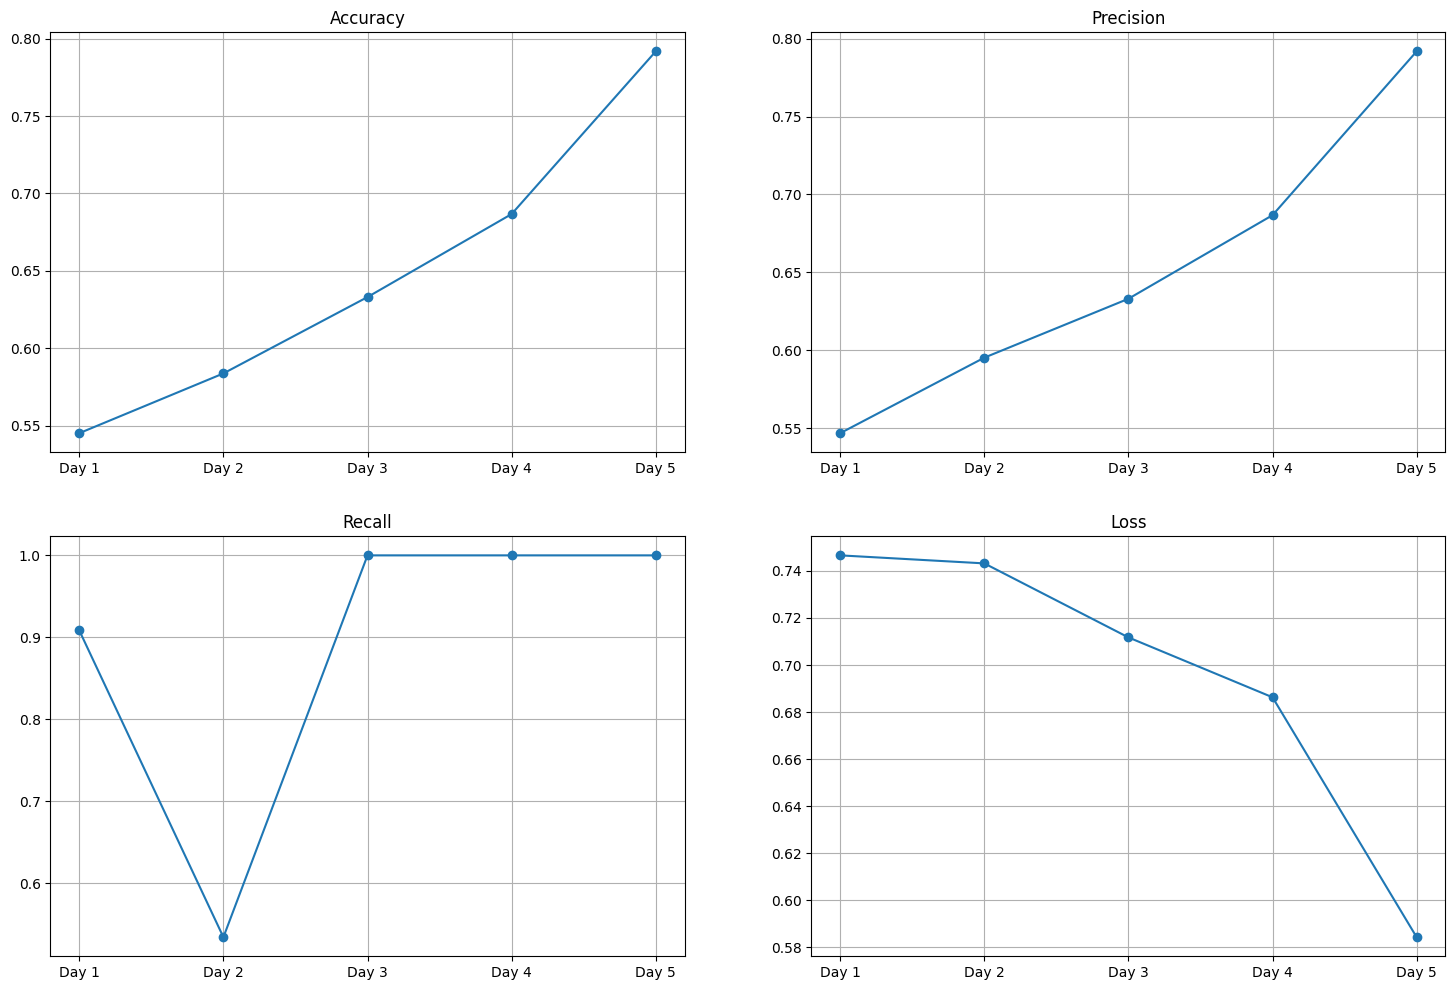

In [22]:
print("=============  HOT ROBERTA CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(hot_roberta,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW ROBERTA CNN  =============== 

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_29 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_29 (Conv1D)             (None, 32, 128)      49280       ['embedding_29[0][0]']           
                                                                                                  
 max_pooling1d_29 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_29[0][0]']              
 )                                       

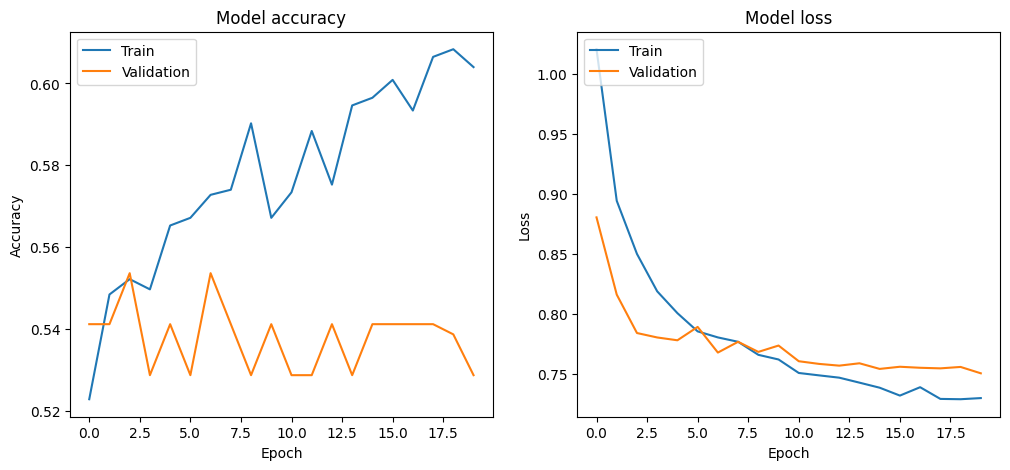

16/16 [==============================] - 0s 4ms/step - loss: 0.7444 - accuracy: 0.5549 - precision: 0.5549 - recall: 1.0000
Test Accuracy for Returns from day  1  : 55.49%
Test Precision for Returns from day  1  : 55.49%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7444
Epoch 1/20
51/51 [==============================] - 11s 164ms/step - loss: 1.0478 - accuracy: 0.5103 - precision: 0.5536 - recall: 0.5636 - val_loss: 0.8556 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 67ms/step - loss: 0.9262 - accuracy: 0.4978 - precision: 0.5398 - recall: 0.5852 - val_loss: 0.8099 - val_accuracy: 0.5087 - val_precision: 0.5161 - val_recall: 0.0808
Epoch 3/20
51/51 [==============================] - 2s 43ms/step - loss: 0.8618 - accuracy: 0.5109 - precision: 0.5506 - recall: 0.6000 - val_loss: 0.7843 - val_accuracy: 0.5187 - val_precision: 0.5333 - val_recall: 0.2020
Epoch 4/20
51/51 

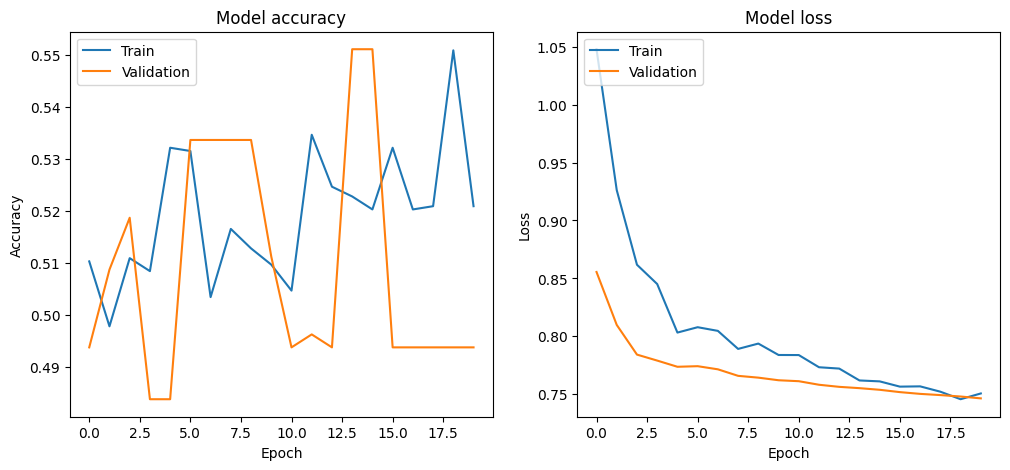

16/16 [==============================] - 0s 4ms/step - loss: 0.7454 - accuracy: 0.5070 - precision: 0.5070 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.70%
Test Precision for Returns from day  2  : 50.70%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7454
Epoch 1/20
51/51 [==============================] - 11s 135ms/step - loss: 0.9932 - accuracy: 0.5540 - precision: 0.6453 - recall: 0.6555 - val_loss: 0.8341 - val_accuracy: 0.4464 - val_precision: 0.5818 - val_recall: 0.1385
Epoch 2/20
51/51 [==============================] - 4s 72ms/step - loss: 0.8702 - accuracy: 0.5796 - precision: 0.6417 - recall: 0.7601 - val_loss: 0.7686 - val_accuracy: 0.6160 - val_precision: 0.6078 - val_recall: 0.9394
Epoch 3/20
51/51 [==============================] - 3s 68ms/step - loss: 0.8468 - accuracy: 0.5646 - precision: 0.6344 - recall: 0.7364 - val_loss: 0.7696 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/20
51/51 

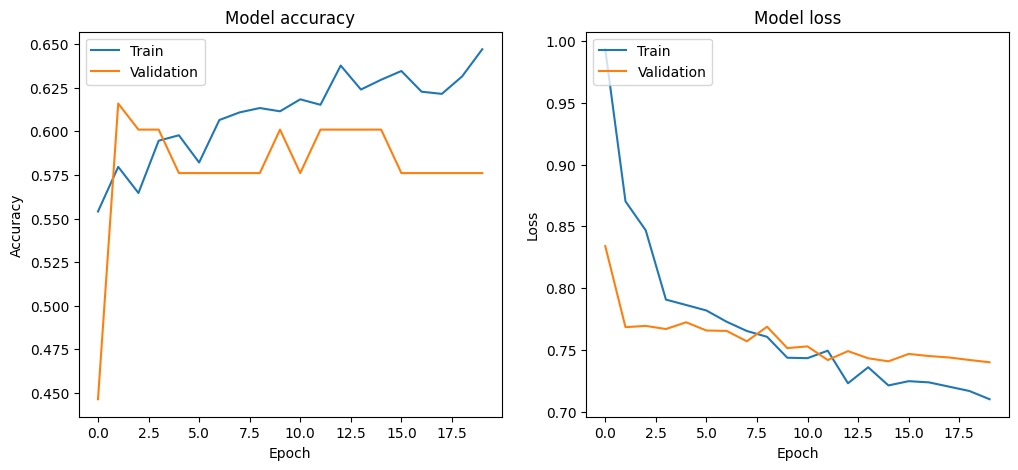

16/16 [==============================] - 0s 4ms/step - loss: 0.7228 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7228
Epoch 1/20
51/51 [==============================] - 10s 146ms/step - loss: 0.9014 - accuracy: 0.6458 - precision: 0.7445 - recall: 0.7953 - val_loss: 0.8207 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 78ms/step - loss: 0.7782 - accuracy: 0.6740 - precision: 0.7390 - recall: 0.8660 - val_loss: 0.7258 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 4s 79ms/step - loss: 0.7433 - accuracy: 0.6808 - precision: 0.7370 - recall: 0.8854 - val_loss: 0.7108 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/20
51/51 

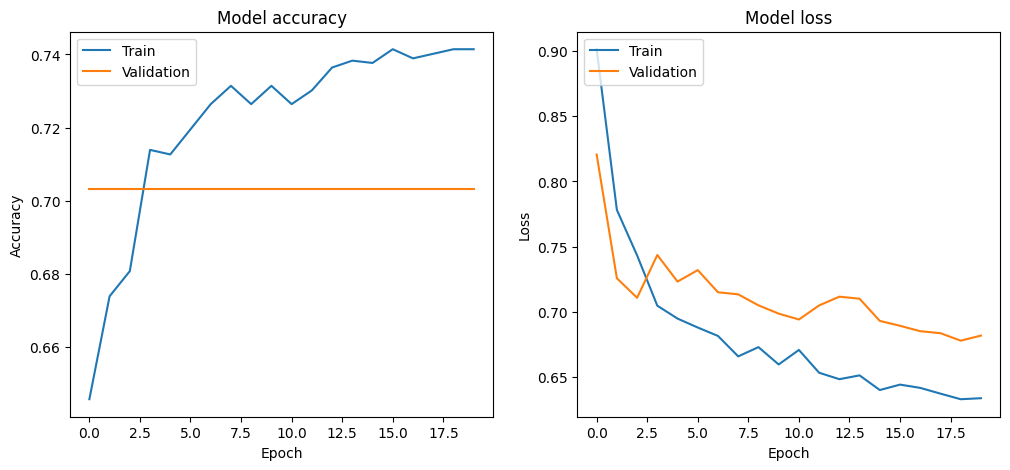

16/16 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6790
Epoch 1/20
51/51 [==============================] - 11s 158ms/step - loss: 0.8854 - accuracy: 0.6808 - precision: 0.8114 - recall: 0.7868 - val_loss: 0.7251 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/20
51/51 [==============================] - 4s 75ms/step - loss: 0.7402 - accuracy: 0.7608 - precision: 0.8096 - recall: 0.9194 - val_loss: 0.6910 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/20
51/51 [==============================] - 3s 58ms/step - loss: 0.6875 - accuracy: 0.7589 - precision: 0.8054 - recall: 0.9240 - val_loss: 0.6881 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 4/20
51/51 

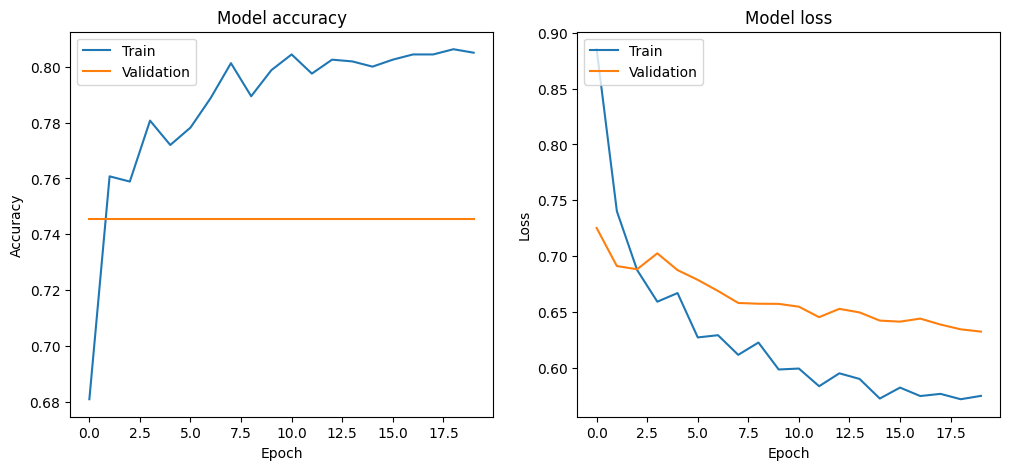

16/16 [==============================] - 0s 6ms/step - loss: 0.6066 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6066


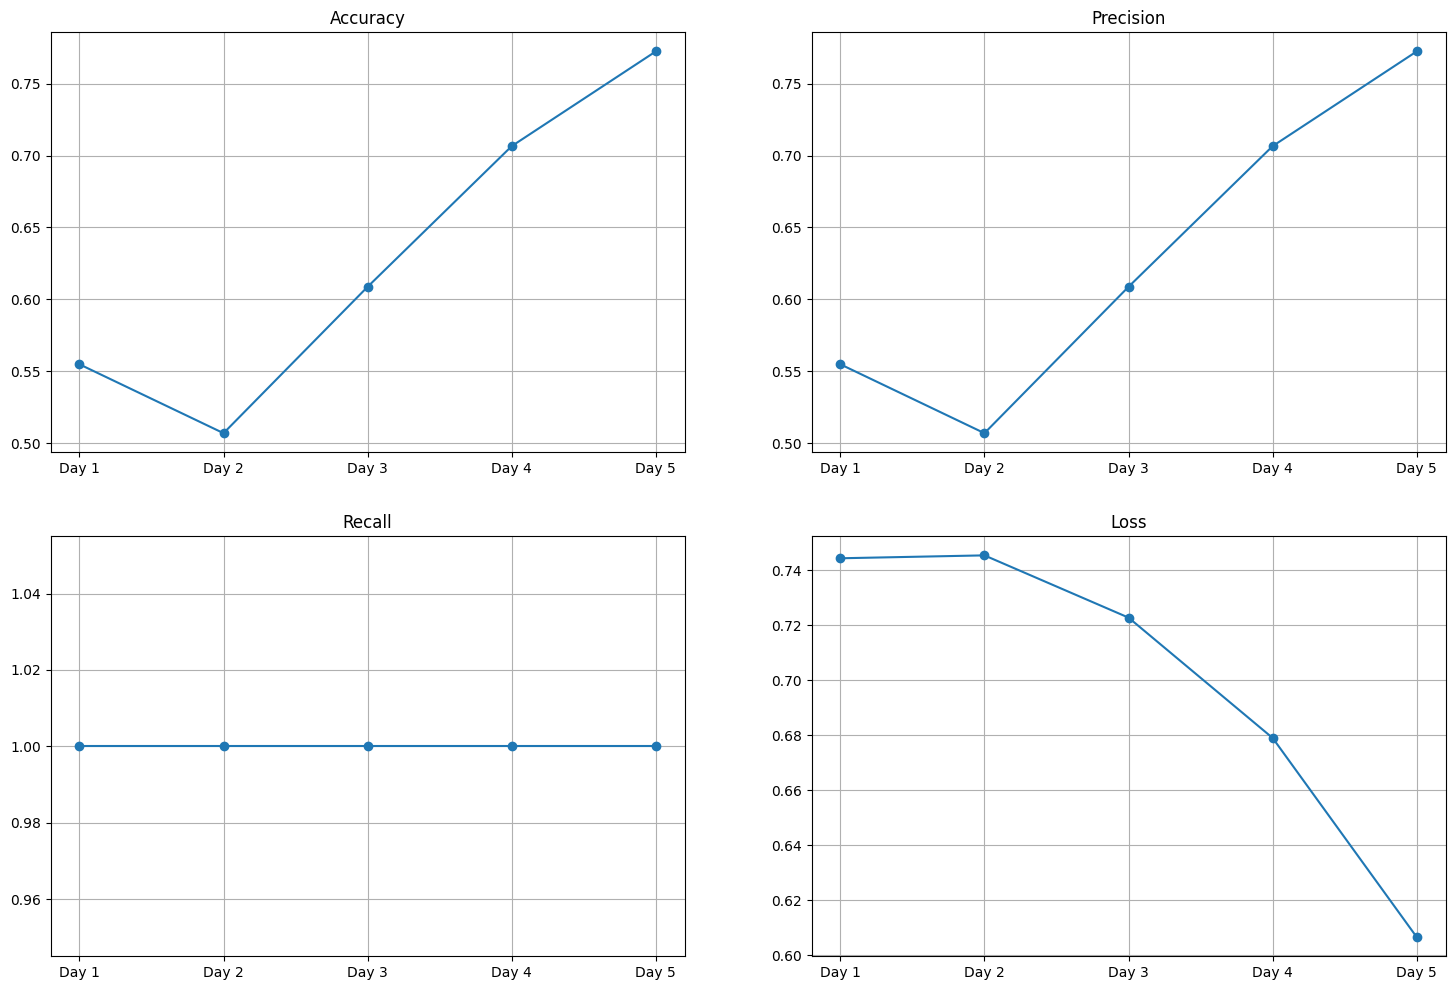

In [23]:
print("=============  NEW ROBERTA CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(new_roberta,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT GPT-3 CNN  =============== 

Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_34 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_34 (Conv1D)             (None, 30, 128)      49280       ['embedding_34[0][0]']           
                                                                                                  
 max_pooling1d_34 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_34[0][0]']              
 )                                         

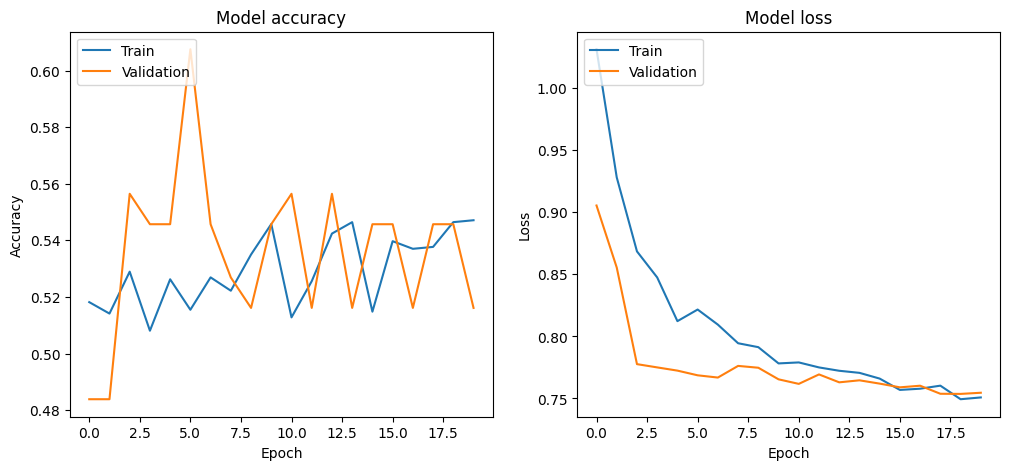

15/15 [==============================] - 0s 7ms/step - loss: 0.7480 - accuracy: 0.5548 - precision: 0.5461 - recall: 0.9184
Test Accuracy for Returns from day  1  : 55.48%
Test Precision for Returns from day  1  : 54.61%
Test Recall for Returns from day  1  : 91.84%
Test Loss for Returns from day  1  : 0.7480
Epoch 1/20
47/47 [==============================] - 10s 159ms/step - loss: 1.0359 - accuracy: 0.5182 - precision: 0.5506 - recall: 0.5533 - val_loss: 0.9813 - val_accuracy: 0.4785 - val_precision: 0.4940 - val_recall: 0.8737
Epoch 2/20
47/47 [==============================] - 4s 76ms/step - loss: 0.9387 - accuracy: 0.5101 - precision: 0.5410 - recall: 0.5709 - val_loss: 0.8044 - val_accuracy: 0.5323 - val_precision: 0.6026 - val_recall: 0.2474
Epoch 3/20
47/47 [==============================] - 3s 56ms/step - loss: 0.8619 - accuracy: 0.5229 - precision: 0.5512 - recall: 0.5947 - val_loss: 0.7927 - val_accuracy: 0.4651 - val_precision: 0.4706 - val_recall: 0.3789
Epoch 4/20
47/47 [

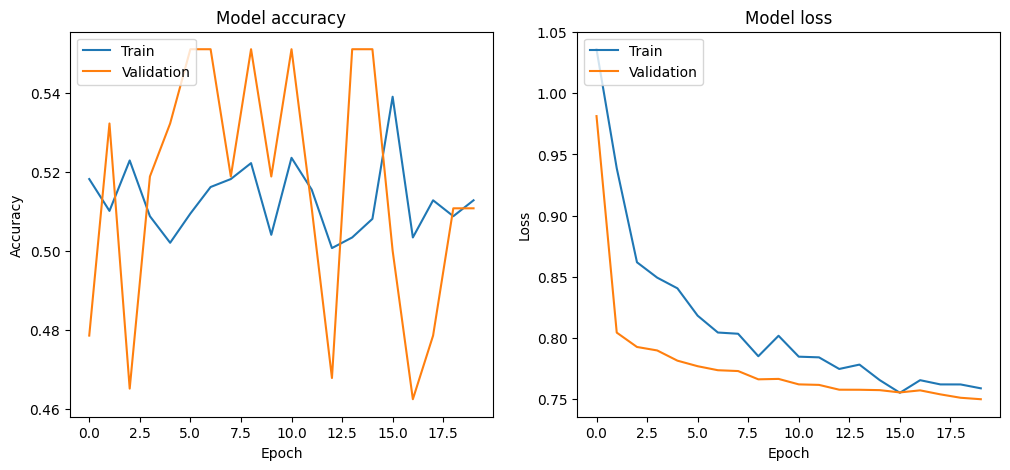

15/15 [==============================] - 0s 4ms/step - loss: 0.7493 - accuracy: 0.4968 - precision: 0.4968 - recall: 1.0000
Test Accuracy for Returns from day  2  : 49.68%
Test Precision for Returns from day  2  : 49.68%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7493
Epoch 1/20
47/47 [==============================] - 11s 168ms/step - loss: 0.9858 - accuracy: 0.5350 - precision: 0.6317 - recall: 0.6106 - val_loss: 0.8440 - val_accuracy: 0.4086 - val_precision: 0.7222 - val_recall: 0.1102
Epoch 2/20
47/47 [==============================] - 3s 66ms/step - loss: 0.8832 - accuracy: 0.5767 - precision: 0.6382 - recall: 0.7422 - val_loss: 0.7536 - val_accuracy: 0.6452 - val_precision: 0.6646 - val_recall: 0.8898
Epoch 3/20
47/47 [==============================] - 2s 50ms/step - loss: 0.8309 - accuracy: 0.5734 - precision: 0.6355 - recall: 0.7411 - val_loss: 0.7345 - val_accuracy: 0.6640 - val_precision: 0.6537 - val_recall: 1.0000
Epoch 4/20
47/47 

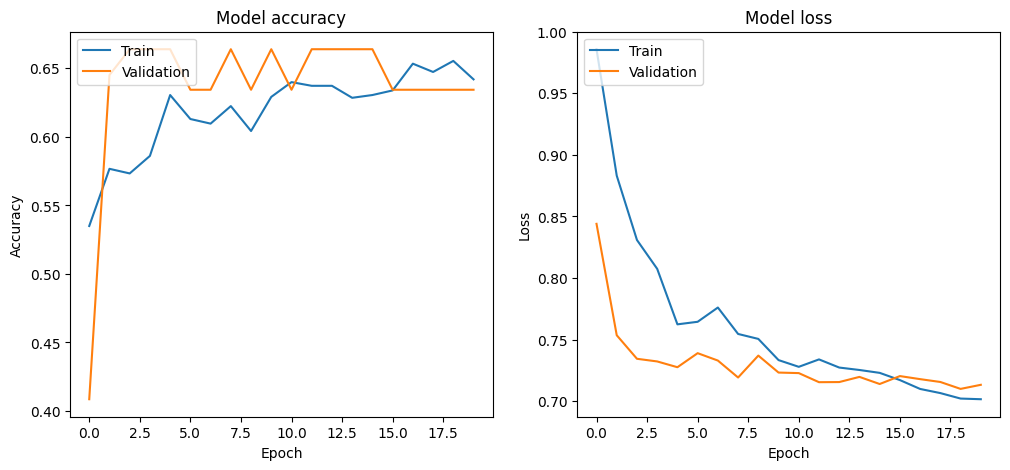

15/15 [==============================] - 0s 6ms/step - loss: 0.7162 - accuracy: 0.6280 - precision: 0.6280 - recall: 1.0000
Test Accuracy for Returns from day  3  : 62.80%
Test Precision for Returns from day  3  : 62.80%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7162
Epoch 1/20
47/47 [==============================] - 9s 122ms/step - loss: 0.9405 - accuracy: 0.6063 - precision: 0.7038 - recall: 0.7648 - val_loss: 0.8323 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 113ms/step - loss: 0.8241 - accuracy: 0.6306 - precision: 0.7045 - recall: 0.8219 - val_loss: 0.7581 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 57ms/step - loss: 0.7728 - accuracy: 0.6561 - precision: 0.7075 - recall: 0.8752 - val_loss: 0.7571 - val_accuracy: 0.6720 - val_precision: 0.6720 - val_recall: 1.0000
Epoch 4/20
47/47 

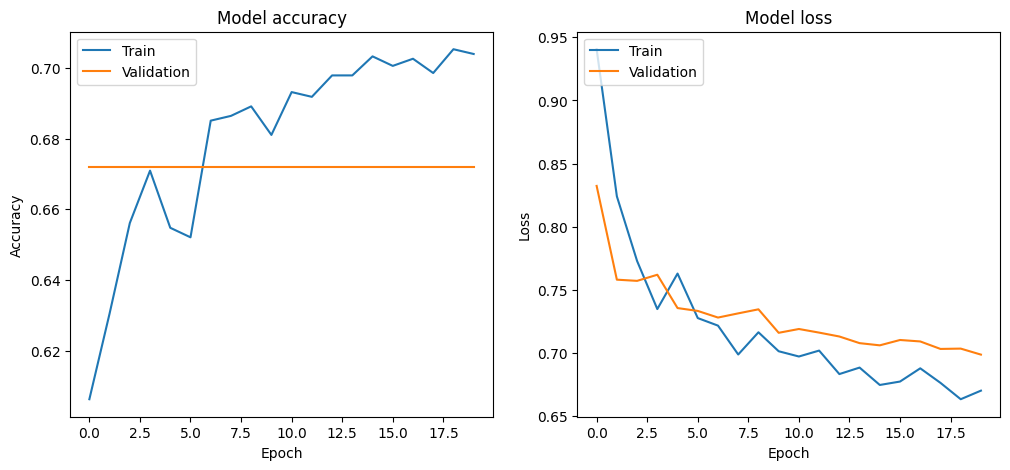

15/15 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.6753 - precision: 0.6753 - recall: 1.0000
Test Accuracy for Returns from day  4  : 67.53%
Test Precision for Returns from day  4  : 67.53%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6950
Epoch 1/20
47/47 [==============================] - 10s 146ms/step - loss: 0.8796 - accuracy: 0.6608 - precision: 0.7973 - recall: 0.7662 - val_loss: 0.7782 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 2/20
47/47 [==============================] - 5s 102ms/step - loss: 0.7731 - accuracy: 0.7301 - precision: 0.7872 - recall: 0.9031 - val_loss: 0.6797 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 3/20
47/47 [==============================] - 3s 59ms/step - loss: 0.7083 - accuracy: 0.7369 - precision: 0.7884 - recall: 0.9124 - val_loss: 0.7016 - val_accuracy: 0.7715 - val_precision: 0.7715 - val_recall: 1.0000
Epoch 4/20
47/47

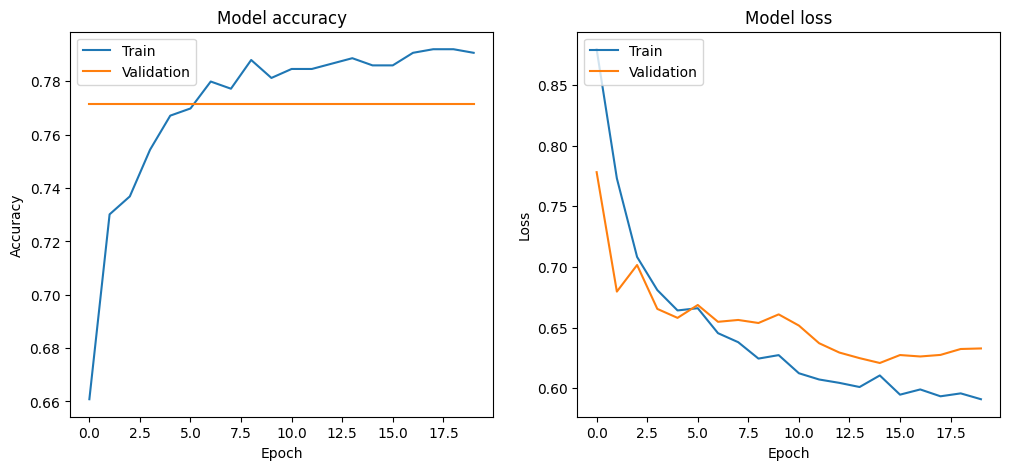

15/15 [==============================] - 0s 5ms/step - loss: 0.6216 - accuracy: 0.7785 - precision: 0.7785 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.85%
Test Precision for Returns from day  5  : 77.85%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6216


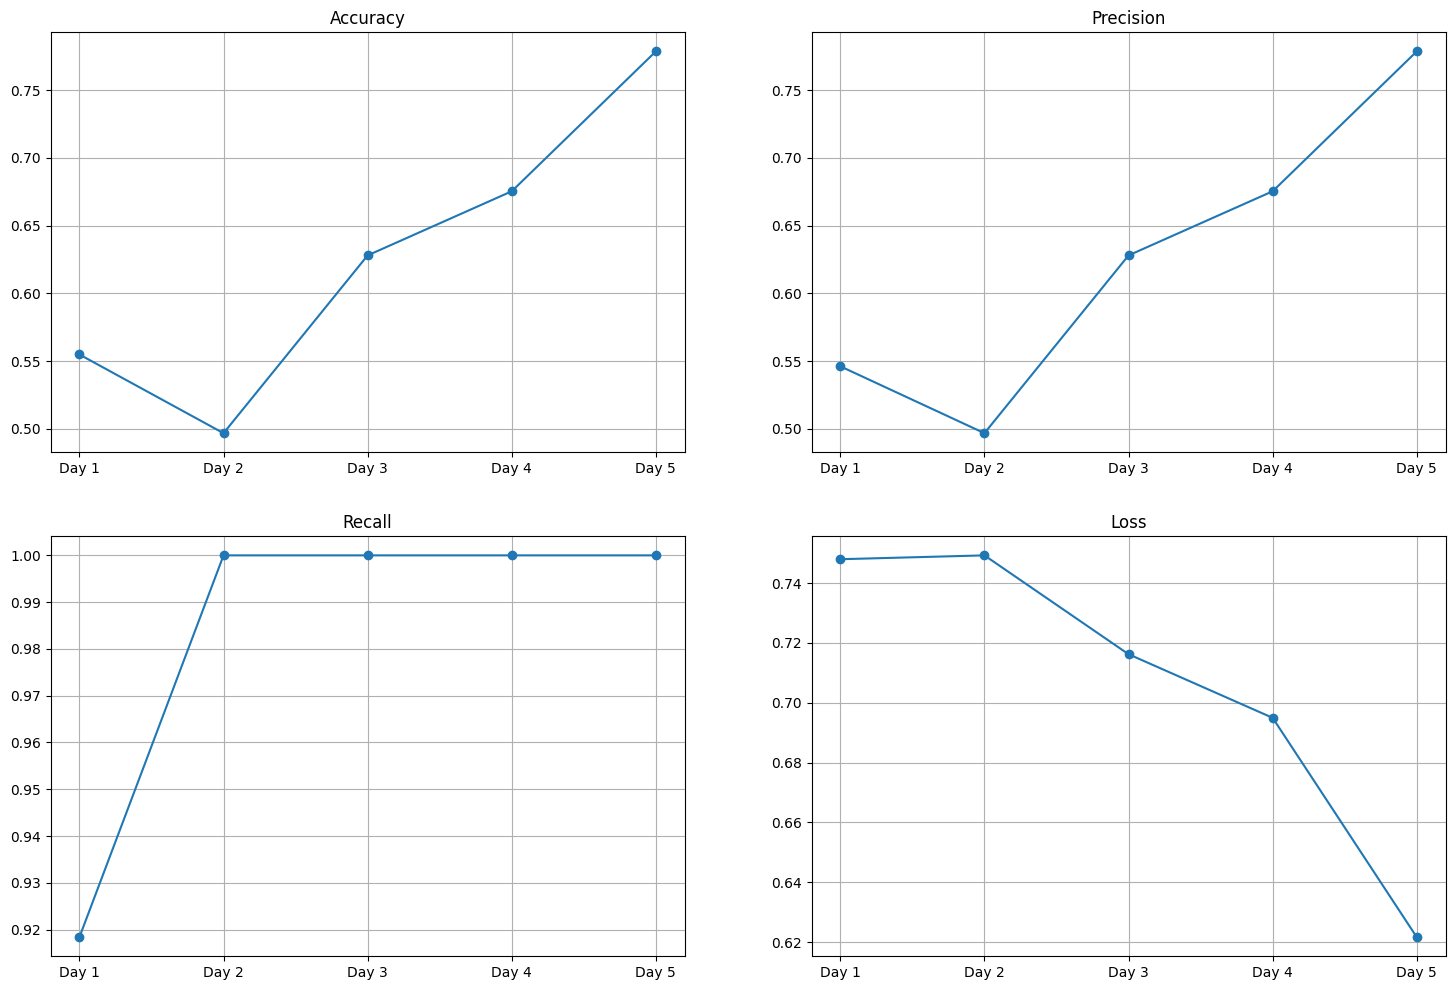

In [24]:
print("=============  HOT GPT-3 CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(hot_chatgpt,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW GPT-3 CNN  =============== 

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_39 (Conv1D)             (None, 32, 128)      49280       ['embedding_39[0][0]']           
                                                                                                  
 max_pooling1d_39 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_39[0][0]']              
 )                                         

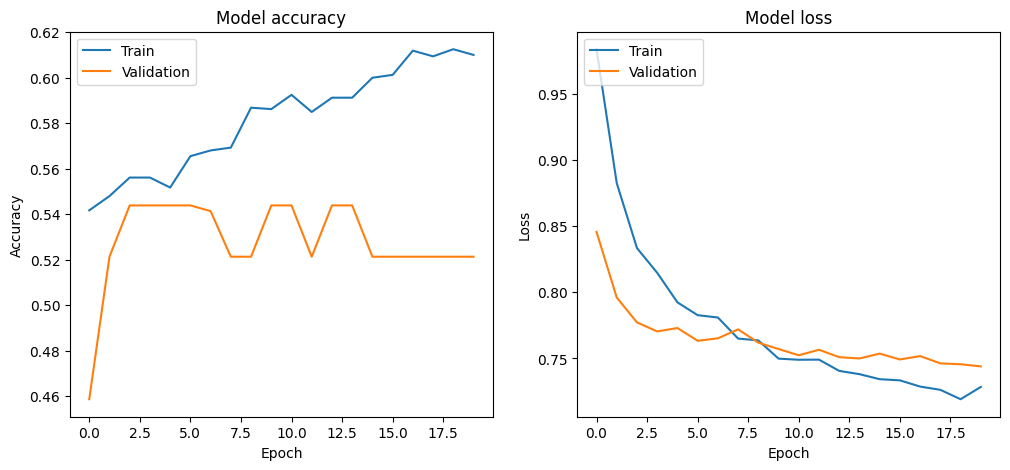

16/16 [==============================] - 0s 6ms/step - loss: 0.7345 - accuracy: 0.5551 - precision: 0.5551 - recall: 1.0000
Test Accuracy for Returns from day  1  : 55.51%
Test Precision for Returns from day  1  : 55.51%
Test Recall for Returns from day  1  : 100.00%
Test Loss for Returns from day  1  : 0.7345
Epoch 1/20
50/50 [==============================] - 10s 124ms/step - loss: 1.0585 - accuracy: 0.5022 - precision: 0.5487 - recall: 0.5336 - val_loss: 0.8875 - val_accuracy: 0.4937 - val_precision: 0.4937 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 3s 58ms/step - loss: 0.9486 - accuracy: 0.5003 - precision: 0.5420 - recall: 0.5884 - val_loss: 0.8001 - val_accuracy: 0.5063 - val_precision: 0.5000 - val_recall: 0.4365
Epoch 3/20
50/50 [==============================] - 4s 85ms/step - loss: 0.9110 - accuracy: 0.4840 - precision: 0.5284 - recall: 0.5724 - val_loss: 0.7870 - val_accuracy: 0.5138 - val_precision: 0.5195 - val_recall: 0.2030
Epoch 4/20
50/50 

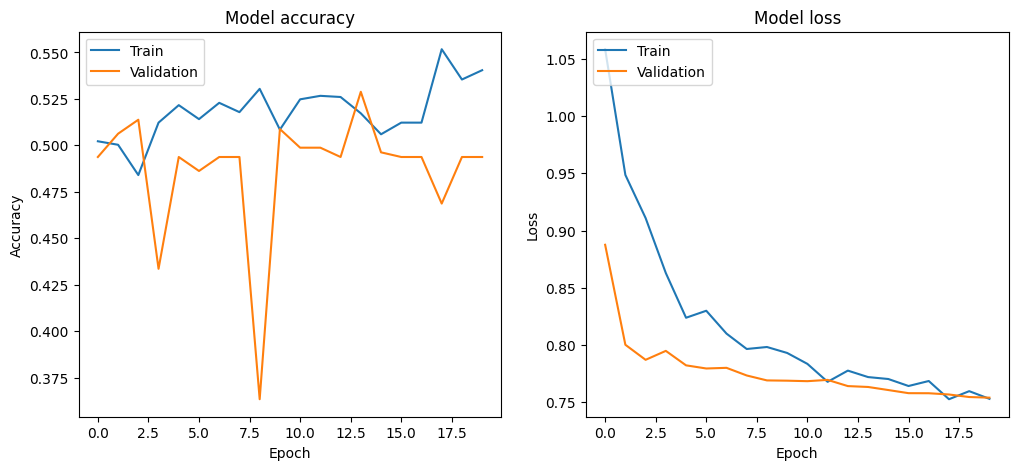

16/16 [==============================] - 0s 4ms/step - loss: 0.7529 - accuracy: 0.5050 - precision: 0.5050 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.50%
Test Precision for Returns from day  2  : 50.50%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7529
Epoch 1/20
50/50 [==============================] - 10s 146ms/step - loss: 0.9840 - accuracy: 0.5636 - precision: 0.6388 - recall: 0.7026 - val_loss: 0.8473 - val_accuracy: 0.4361 - val_precision: 0.6111 - val_recall: 0.0944
Epoch 2/20
50/50 [==============================] - 4s 71ms/step - loss: 0.8576 - accuracy: 0.5762 - precision: 0.6386 - recall: 0.7495 - val_loss: 0.7904 - val_accuracy: 0.5840 - val_precision: 0.5840 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 2s 33ms/step - loss: 0.8190 - accuracy: 0.5843 - precision: 0.6368 - recall: 0.7874 - val_loss: 0.7639 - val_accuracy: 0.6065 - val_precision: 0.5974 - val_recall: 1.0000
Epoch 4/20
50/50 

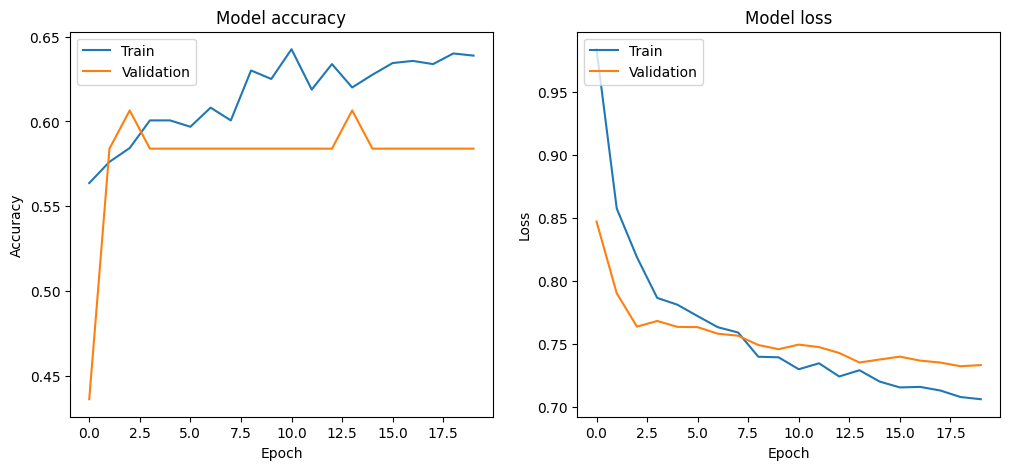

16/16 [==============================] - 0s 4ms/step - loss: 0.7197 - accuracy: 0.6152 - precision: 0.6152 - recall: 1.0000
Test Accuracy for Returns from day  3  : 61.52%
Test Precision for Returns from day  3  : 61.52%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7197
Epoch 1/20
50/50 [==============================] - 11s 155ms/step - loss: 0.9225 - accuracy: 0.6307 - precision: 0.7429 - recall: 0.7600 - val_loss: 0.7503 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 3s 60ms/step - loss: 0.7803 - accuracy: 0.6777 - precision: 0.7393 - recall: 0.8668 - val_loss: 0.7281 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 2s 47ms/step - loss: 0.7460 - accuracy: 0.6966 - precision: 0.7374 - recall: 0.9112 - val_loss: 0.7256 - val_accuracy: 0.7068 - val_precision: 0.7068 - val_recall: 1.0000
Epoch 4/20
50/50 

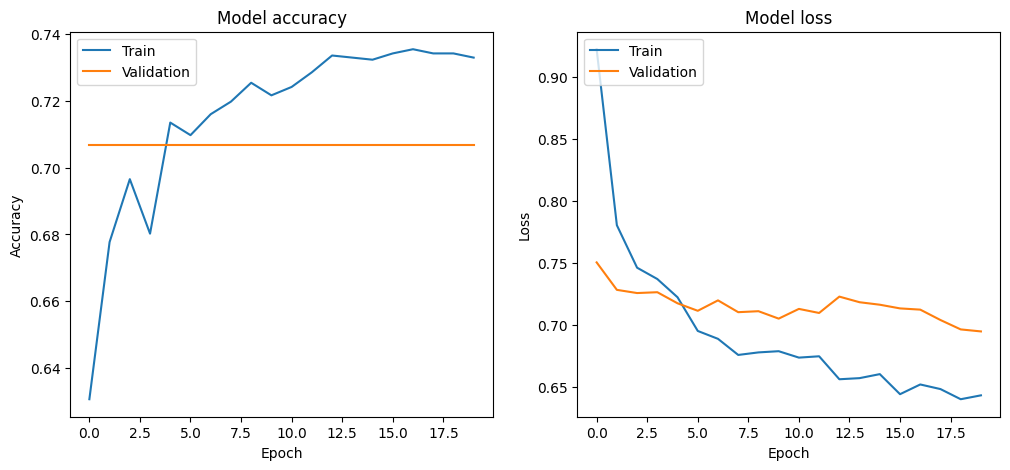

16/16 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.7234 - precision: 0.7234 - recall: 1.0000
Test Accuracy for Returns from day  4  : 72.34%
Test Precision for Returns from day  4  : 72.34%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.6868
Epoch 1/20
50/50 [==============================] - 9s 124ms/step - loss: 0.8087 - accuracy: 0.7141 - precision: 0.7993 - recall: 0.8582 - val_loss: 0.7427 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 2/20
50/50 [==============================] - 4s 78ms/step - loss: 0.6998 - accuracy: 0.7611 - precision: 0.7993 - recall: 0.9365 - val_loss: 0.6877 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 3/20
50/50 [==============================] - 6s 113ms/step - loss: 0.6592 - accuracy: 0.7724 - precision: 0.8041 - recall: 0.9459 - val_loss: 0.6683 - val_accuracy: 0.7444 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 4/20
50/50 

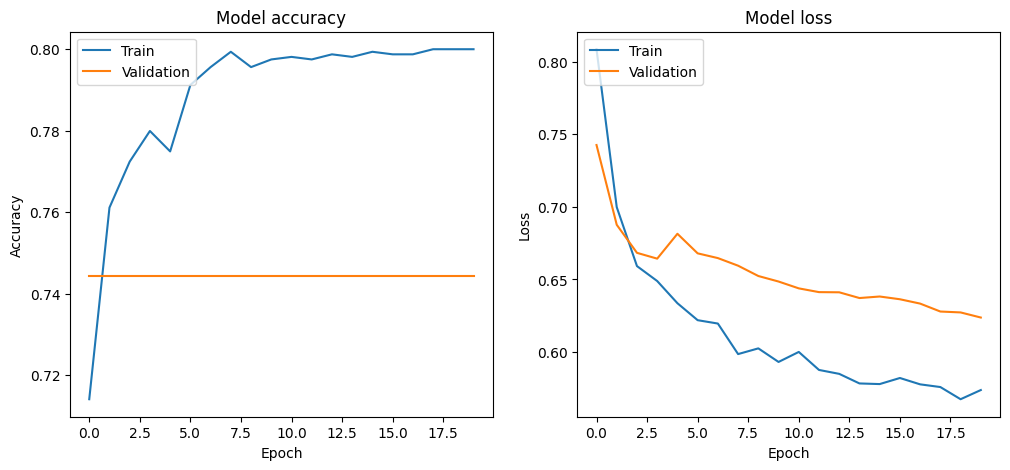

16/16 [==============================] - 0s 4ms/step - loss: 0.5792 - accuracy: 0.7916 - precision: 0.7916 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.16%
Test Precision for Returns from day  5  : 79.16%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.5792


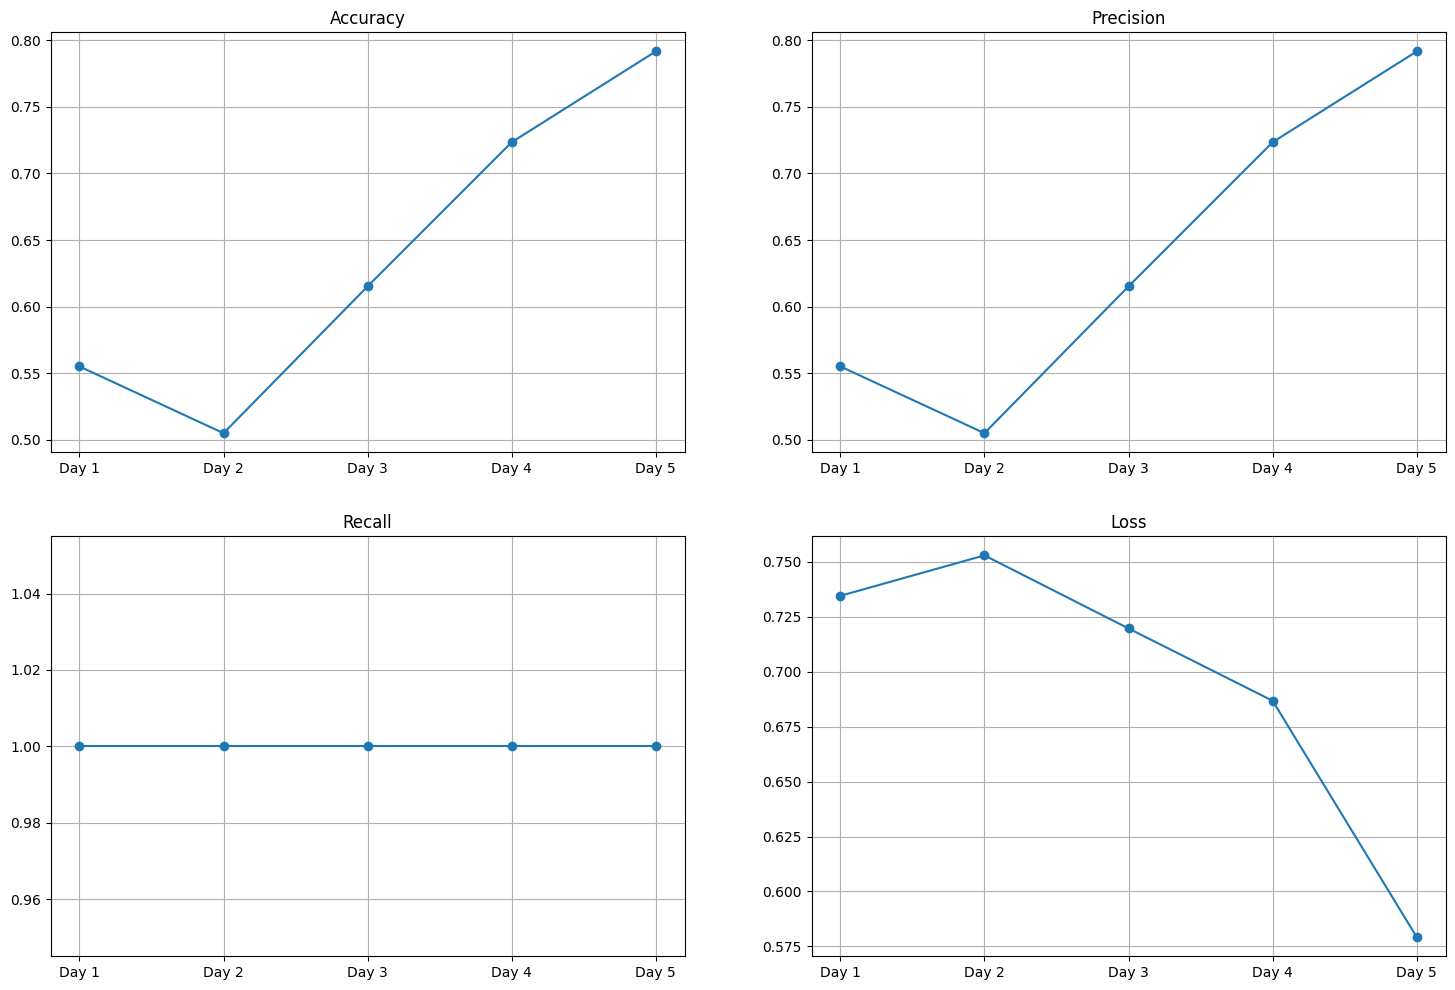

In [25]:
print("=============  NEW GPT-3 CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly(new_chatgpt,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  HOT VADER CNN  =============== 

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 embedding_44 (Embedding)       (None, 32, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_44 (Conv1D)             (None, 30, 128)      49280       ['embedding_44[0][0]']           
                                                                                                  
 max_pooling1d_44 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_44[0][0]']              
 )                                         

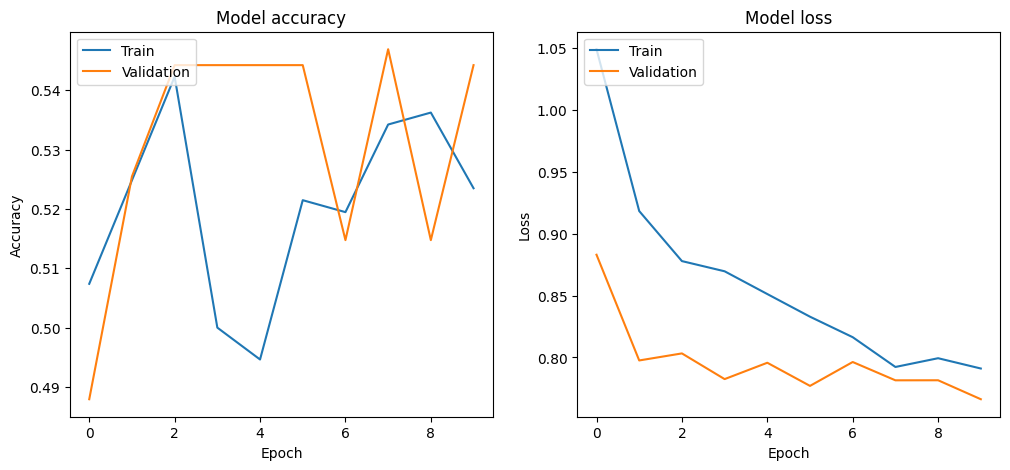

15/15 [==============================] - 0s 5ms/step - loss: 0.7565 - accuracy: 0.5815 - precision: 0.5700 - recall: 0.9084
Test Accuracy for Returns from day  1  : 58.15%
Test Precision for Returns from day  1  : 57.00%
Test Recall for Returns from day  1  : 90.84%
Test Loss for Returns from day  1  : 0.7565
Epoch 1/10
47/47 [==============================] - 10s 136ms/step - loss: 1.0146 - accuracy: 0.5208 - precision: 0.5608 - recall: 0.4749 - val_loss: 0.8763 - val_accuracy: 0.5147 - val_precision: 0.5147 - val_recall: 1.0000
Epoch 2/10
47/47 [==============================] - 4s 83ms/step - loss: 0.9177 - accuracy: 0.5208 - precision: 0.5483 - recall: 0.5842 - val_loss: 0.8029 - val_accuracy: 0.4879 - val_precision: 0.5054 - val_recall: 0.2448
Epoch 3/10
47/47 [==============================] - 4s 86ms/step - loss: 0.8798 - accuracy: 0.4940 - precision: 0.5253 - recall: 0.5477 - val_loss: 0.7892 - val_accuracy: 0.5147 - val_precision: 0.5797 - val_recall: 0.2083
Epoch 4/10
47/47 [

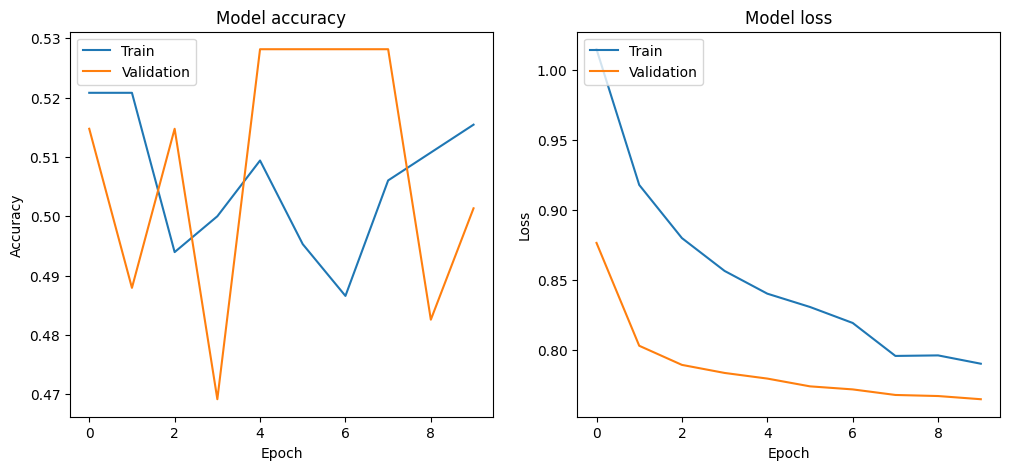

15/15 [==============================] - 0s 4ms/step - loss: 0.7631 - accuracy: 0.5300 - precision: 0.5701 - recall: 0.2607
Test Accuracy for Returns from day  2  : 53.00%
Test Precision for Returns from day  2  : 57.01%
Test Recall for Returns from day  2  : 26.07%
Test Loss for Returns from day  2  : 0.7631
Epoch 1/10
47/47 [==============================] - 10s 148ms/step - loss: 1.0397 - accuracy: 0.5302 - precision: 0.6134 - recall: 0.6558 - val_loss: 0.8122 - val_accuracy: 0.6408 - val_precision: 0.7023 - val_recall: 0.7667
Epoch 2/10
47/47 [==============================] - 4s 96ms/step - loss: 0.8689 - accuracy: 0.5658 - precision: 0.6330 - recall: 0.7132 - val_loss: 0.7314 - val_accuracy: 0.6863 - val_precision: 0.6847 - val_recall: 0.9500
Epoch 3/10
47/47 [==============================] - 3s 74ms/step - loss: 0.8392 - accuracy: 0.5906 - precision: 0.6392 - recall: 0.7803 - val_loss: 0.7285 - val_accuracy: 0.6729 - val_precision: 0.6630 - val_recall: 1.0000
Epoch 4/10
47/47 [

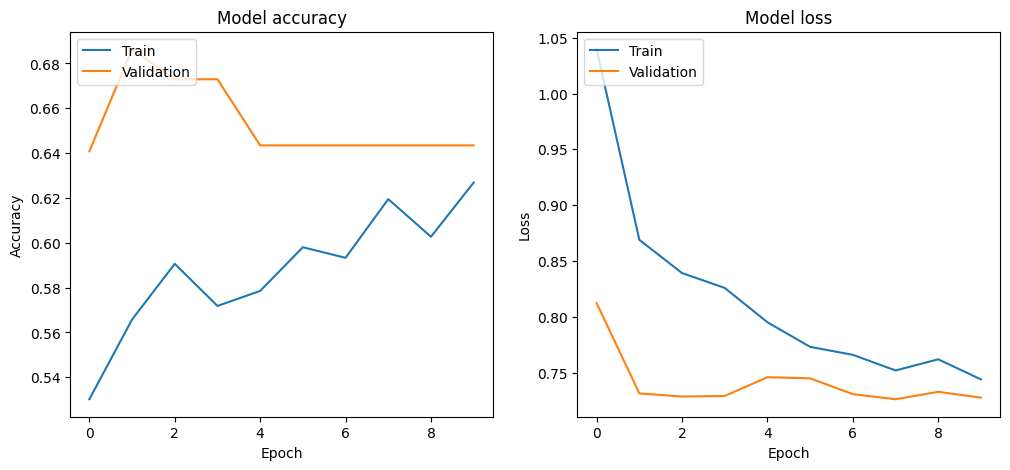

15/15 [==============================] - 0s 5ms/step - loss: 0.7312 - accuracy: 0.6330 - precision: 0.6330 - recall: 1.0000
Test Accuracy for Returns from day  3  : 63.30%
Test Precision for Returns from day  3  : 63.30%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7312
Epoch 1/10
47/47 [==============================] - 11s 173ms/step - loss: 0.9136 - accuracy: 0.6497 - precision: 0.7123 - recall: 0.8427 - val_loss: 0.7942 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 2/10
47/47 [==============================] - 3s 60ms/step - loss: 0.8332 - accuracy: 0.6510 - precision: 0.7058 - recall: 0.8646 - val_loss: 0.7514 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.7843 - accuracy: 0.6389 - precision: 0.6946 - recall: 0.8694 - val_loss: 0.7376 - val_accuracy: 0.6676 - val_precision: 0.6676 - val_recall: 1.0000
Epoch 4/10
47/47 

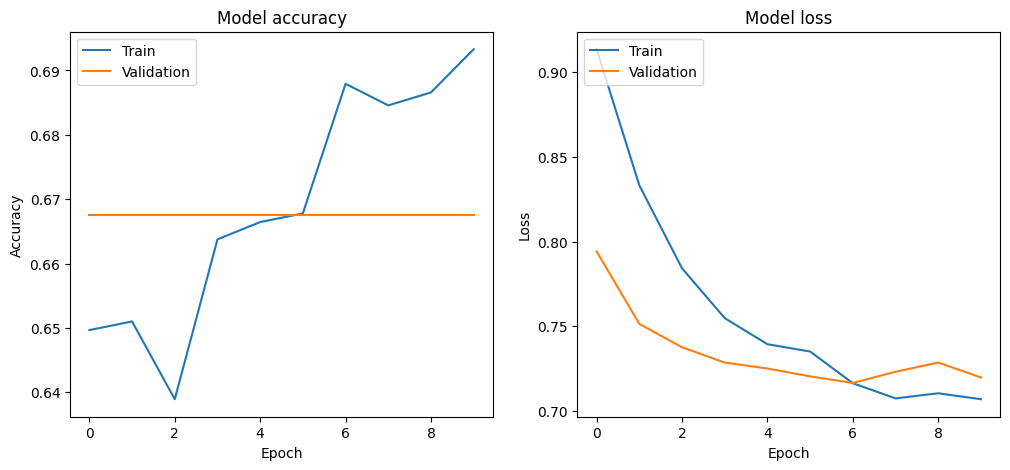

15/15 [==============================] - 0s 4ms/step - loss: 0.7135 - accuracy: 0.6867 - precision: 0.6867 - recall: 1.0000
Test Accuracy for Returns from day  4  : 68.67%
Test Precision for Returns from day  4  : 68.67%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.7135
Epoch 1/10
47/47 [==============================] - 10s 163ms/step - loss: 0.8518 - accuracy: 0.6960 - precision: 0.7866 - recall: 0.8423 - val_loss: 0.7035 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 2/10
47/47 [==============================] - 4s 79ms/step - loss: 0.7151 - accuracy: 0.7463 - precision: 0.7887 - recall: 0.9258 - val_loss: 0.7013 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 3/10
47/47 [==============================] - 2s 47ms/step - loss: 0.7091 - accuracy: 0.7537 - precision: 0.7895 - recall: 0.9369 - val_loss: 0.6657 - val_accuracy: 0.7694 - val_precision: 0.7694 - val_recall: 1.0000
Epoch 4/10
47/47 

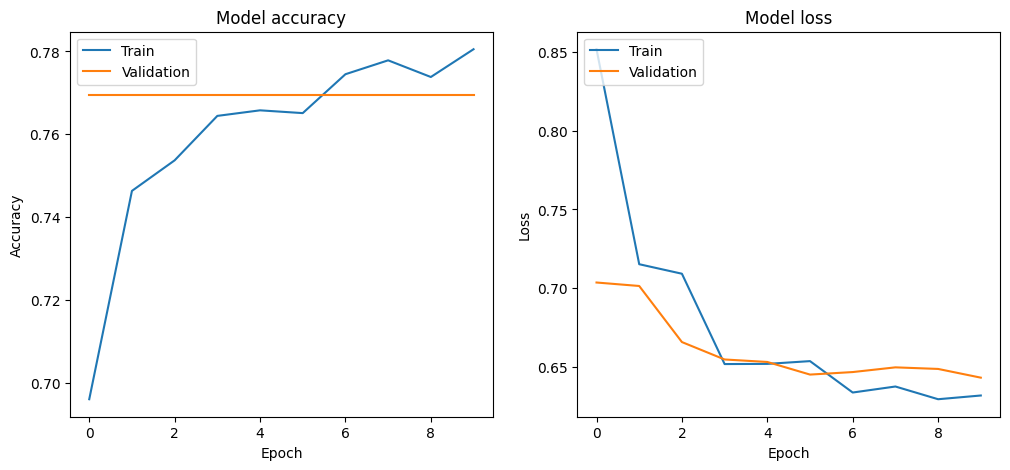

15/15 [==============================] - 0s 4ms/step - loss: 0.6218 - accuracy: 0.7918 - precision: 0.7918 - recall: 1.0000
Test Accuracy for Returns from day  5  : 79.18%
Test Precision for Returns from day  5  : 79.18%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6218


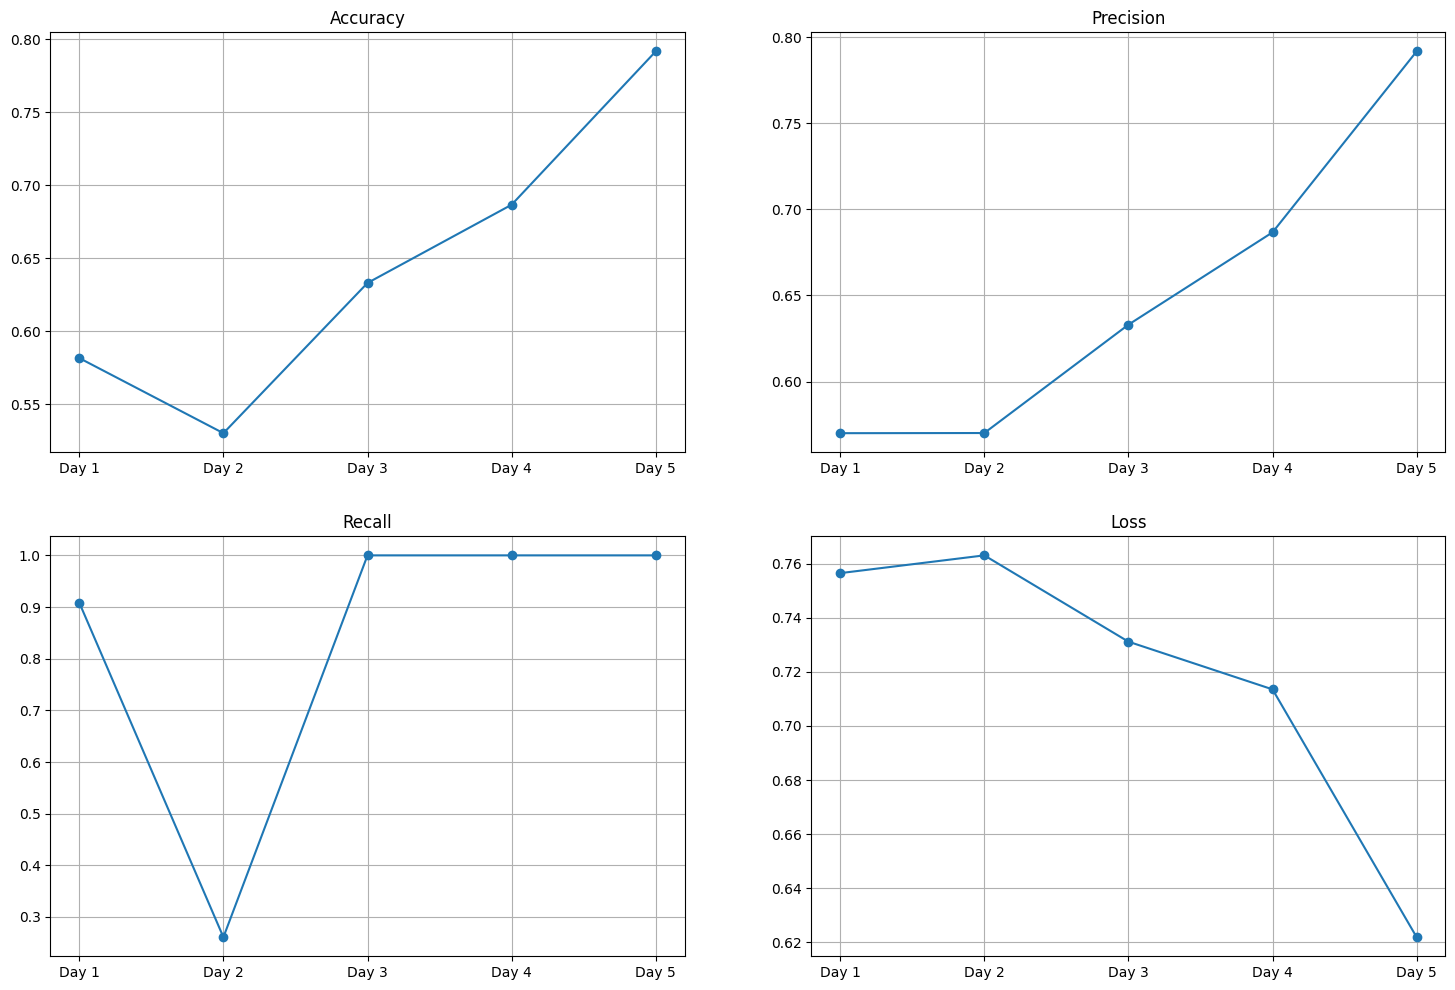

In [30]:
print("=============  HOT VADER CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly_vader(hot_vader,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)

=============  NEW VADER CNN  =============== 

Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 embedding_49 (Embedding)       (None, 34, 128)      1280000     ['text_input[0][0]']             
                                                                                                  
 conv1d_49 (Conv1D)             (None, 32, 128)      49280       ['embedding_49[0][0]']           
                                                                                                  
 max_pooling1d_49 (MaxPooling1D  (None, 10, 128)     0           ['conv1d_49[0][0]']              
 )                                         

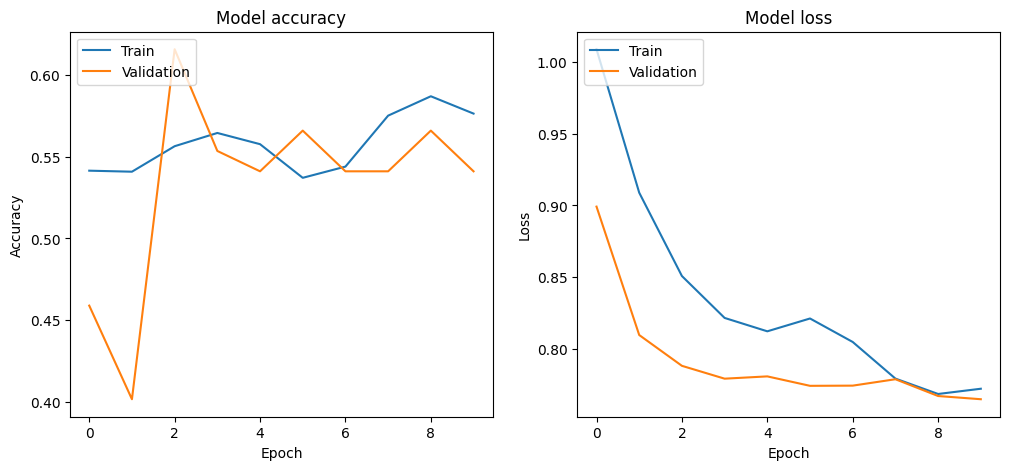

16/16 [==============================] - 0s 4ms/step - loss: 0.7608 - accuracy: 0.5609 - precision: 0.5636 - recall: 0.9245
Test Accuracy for Returns from day  1  : 56.09%
Test Precision for Returns from day  1  : 56.36%
Test Recall for Returns from day  1  : 92.45%
Test Loss for Returns from day  1  : 0.7608
Epoch 1/10
51/51 [==============================] - 11s 155ms/step - loss: 1.0498 - accuracy: 0.5134 - precision: 0.5560 - recall: 0.5693 - val_loss: 0.9540 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 2/10
51/51 [==============================] - 4s 80ms/step - loss: 0.9384 - accuracy: 0.4878 - precision: 0.5305 - recall: 0.5920 - val_loss: 0.8011 - val_accuracy: 0.5137 - val_precision: 0.5056 - val_recall: 0.6869
Epoch 3/10
51/51 [==============================] - 2s 43ms/step - loss: 0.8574 - accuracy: 0.5128 - precision: 0.5510 - recall: 0.6136 - val_loss: 0.7951 - val_accuracy: 0.4938 - val_precision: 0.4938 - val_recall: 1.0000
Epoch 4/10
51/51 [

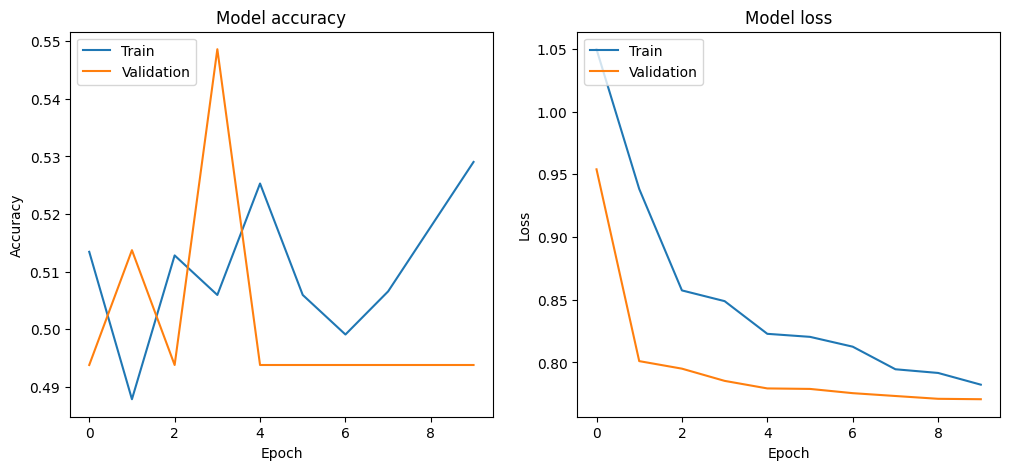

16/16 [==============================] - 0s 4ms/step - loss: 0.7686 - accuracy: 0.5070 - precision: 0.5070 - recall: 1.0000
Test Accuracy for Returns from day  2  : 50.70%
Test Precision for Returns from day  2  : 50.70%
Test Recall for Returns from day  2  : 100.00%
Test Loss for Returns from day  2  : 0.7686
Epoch 1/10
51/51 [==============================] - 11s 132ms/step - loss: 0.9733 - accuracy: 0.5628 - precision: 0.6389 - recall: 0.7108 - val_loss: 0.8184 - val_accuracy: 0.5761 - val_precision: 0.5761 - val_recall: 1.0000
Epoch 2/10
51/51 [==============================] - 4s 75ms/step - loss: 0.8646 - accuracy: 0.5653 - precision: 0.6322 - recall: 0.7483 - val_loss: 0.7699 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 3/10
51/51 [==============================] - 3s 65ms/step - loss: 0.8140 - accuracy: 0.5778 - precision: 0.6326 - recall: 0.7937 - val_loss: 0.7606 - val_accuracy: 0.6010 - val_precision: 0.5908 - val_recall: 1.0000
Epoch 4/10
51/51 

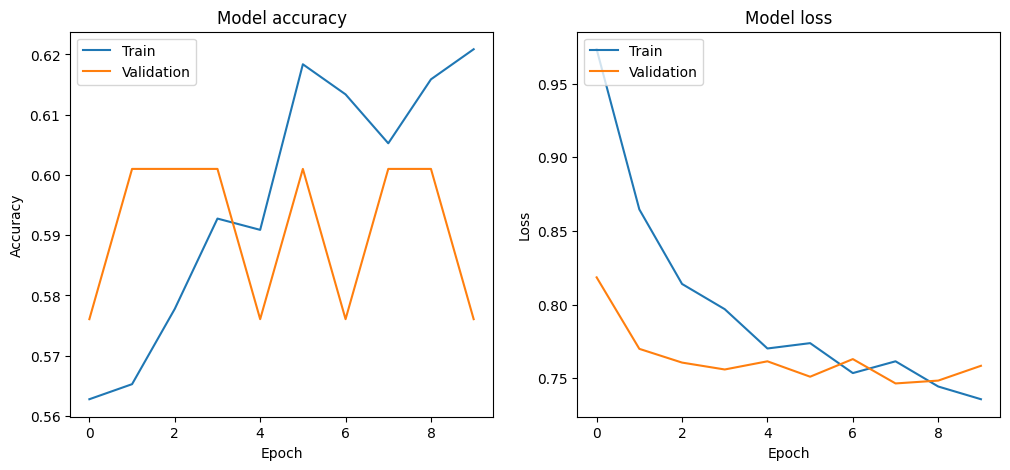

16/16 [==============================] - 0s 7ms/step - loss: 0.7408 - accuracy: 0.6088 - precision: 0.6088 - recall: 1.0000
Test Accuracy for Returns from day  3  : 60.88%
Test Precision for Returns from day  3  : 60.88%
Test Recall for Returns from day  3  : 100.00%
Test Loss for Returns from day  3  : 0.7408
Epoch 1/10
51/51 [==============================] - 10s 141ms/step - loss: 1.0853 - accuracy: 0.5422 - precision: 0.7316 - recall: 0.6040 - val_loss: 0.9428 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 2/10
51/51 [==============================] - 5s 99ms/step - loss: 0.8293 - accuracy: 0.6558 - precision: 0.7431 - recall: 0.8189 - val_loss: 0.7296 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 3/10
51/51 [==============================] - 2s 40ms/step - loss: 0.7799 - accuracy: 0.6783 - precision: 0.7410 - recall: 0.8703 - val_loss: 0.7276 - val_accuracy: 0.7032 - val_precision: 0.7032 - val_recall: 1.0000
Epoch 4/10
51/51 

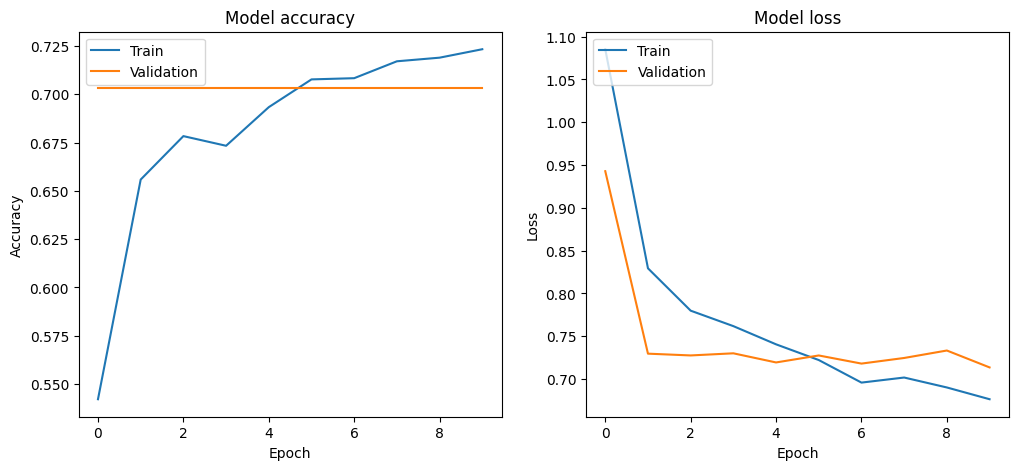

16/16 [==============================] - 0s 6ms/step - loss: 0.7102 - accuracy: 0.7066 - precision: 0.7066 - recall: 1.0000
Test Accuracy for Returns from day  4  : 70.66%
Test Precision for Returns from day  4  : 70.66%
Test Recall for Returns from day  4  : 100.00%
Test Loss for Returns from day  4  : 0.7102
Epoch 1/10
51/51 [==============================] - 10s 144ms/step - loss: 0.7734 - accuracy: 0.7589 - precision: 0.8054 - recall: 0.9240 - val_loss: 0.7382 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 2/10
51/51 [==============================] - 5s 105ms/step - loss: 0.6990 - accuracy: 0.7726 - precision: 0.8022 - recall: 0.9527 - val_loss: 0.6856 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 3/10
51/51 [==============================] - 2s 37ms/step - loss: 0.6356 - accuracy: 0.7858 - precision: 0.8061 - recall: 0.9667 - val_loss: 0.6666 - val_accuracy: 0.7456 - val_precision: 0.7456 - val_recall: 1.0000
Epoch 4/10
51/51

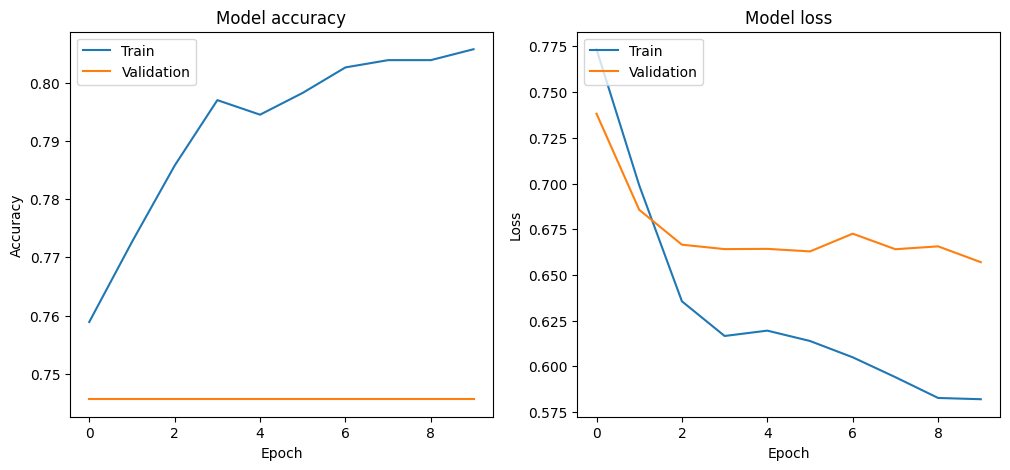

16/16 [==============================] - 0s 6ms/step - loss: 0.6362 - accuracy: 0.7725 - precision: 0.7725 - recall: 1.0000
Test Accuracy for Returns from day  5  : 77.25%
Test Precision for Returns from day  5  : 77.25%
Test Recall for Returns from day  5  : 100.00%
Test Loss for Returns from day  5  : 0.6362


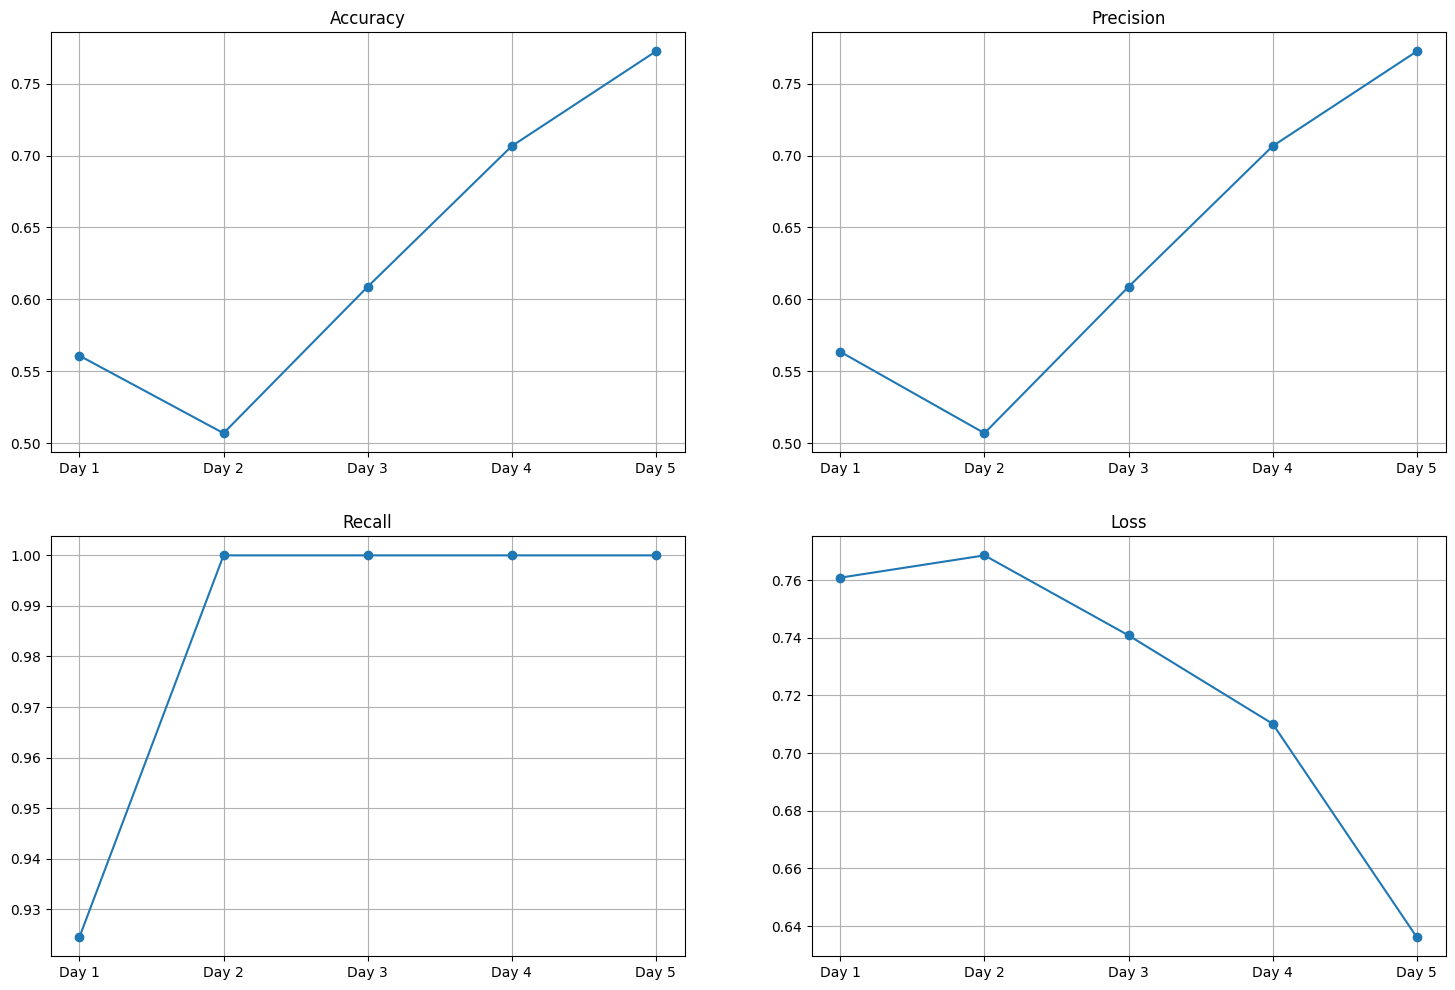

In [31]:
print("=============  NEW VADER CNN  =============== \n")
accuracy =[]
precision=[]
recall =[]
loss=[]
for i in range(1,6):
  evaluation = model_CNN_weekly_vader(new_vader,i)
  loss.append(evaluation[0])
  accuracy.append(evaluation[1])
  precision.append(evaluation[2])
  recall.append(evaluation[3])

plot_week_eval(accuracy,precision,recall,loss)